In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import hydra
import os
import numpy as np
import wandb

In [3]:
import pickle
from pathlib import Path

In [4]:
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch import nn
from torchvision import transforms
import torchcontrib
from sklearn.utils.class_weight import compute_class_weight
import hydra
from hydra.experimental import compose, initialize

In [5]:
from hw_grapheme.io.load_data import load_processed_data
from hw_grapheme.model_archs.se_resnext import se_resnext50
from hw_grapheme.models.train import train_model
from hw_grapheme.train_utils.create_dataloader import create_dataloaders_train
from hw_grapheme.train_utils.train_test_split import stratified_split_kfold
from omegaconf import DictConfig
from tqdm.notebook import tqdm

In [6]:
initialize(
    config_dir="configs", strict=True,
)

# Init

In [7]:
EXP_NAME = "regression"
MACHINE = "1080ti"
IS_WEIGHT_CLASS = False

In [8]:
overrides = [f"exp_name={EXP_NAME}", f"machine={MACHINE}"]

In [9]:
cfg = compose("config.yaml", overrides=overrides)
print(cfg.pretty())

# Assign Config

if cfg.exp_name =='base': 
    raise ValueError('Give me a proper exp name')
print('EXP NAME', cfg.exp_name)
print('====='*20)
print(cfg.pretty())

if cfg.mix_precision:
    # 1080ti can't use mix precision & Window issue
    from apex import amp

DATA_PATH = Path(cfg.DATA_PATH)
random_seed = cfg.random_seed

# load processed data
pickle_paths = [
#         DATA_PATH/"sample.pickle",
    DATA_PATH/"train_data_0.pickle",
    #     DATA_PATH/"train_data_1.pickle",
    #     DATA_PATH/"train_data_2.pickle",
    #     DATA_PATH/"train_data_3.pickle",
]

image_data, name_data, label_data = load_processed_data(
    pickle_paths, image_size=128)

# +
# split train valid set
n_splits = cfg.n_splits
random_speed = cfg.random_seed

train_idx_list, test_idx_list = stratified_split_kfold(
    image_data, label_data, n_splits, random_seed
)

# +
# default training setting
num_workers = cfg.num_workers
pin_memory = cfg.pin_memory
fold = list(range(n_splits))

# customize training setting
n_epoch = cfg.n_epoch
batch_size = cfg.batch_size
mixed_precision = cfg.mix_precision

model_arch = eval(cfg.model_arch)
model_parameter = cfg.model_parameter
# model_parameter = eval(cfg.model_parameter)

# import image transforms config
rotate = cfg.data_transforms.rotate
scale = cfg.data_transforms.scale
p_affine = cfg.data_transforms.p_affine
data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomApply(
            [transforms.RandomAffine(degrees=rotate, scale=tuple(scale))],
            p=p_affine,
        ),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        # transforms.Normalize([0.0692], [0.2051]),
    ]),
    'val': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        # transforms.Normalize([0.0692], [0.2051])
    ]),
}

swa = cfg.swa

optimizer = eval(cfg.optimizer)
print('OPTIM', optimizer, type(optimizer))
optimizer_parameter = cfg.optimizer_parameter
is_weighted_class_loss = cfg.is_weighted_class_loss

# create lr scheduler
epoch_scheduler_func = eval(cfg.epoch_scheduler_func)
epoch_scheduler_func_para = cfg.epoch_scheduler_func_para
error_plateau_scheduler_func = eval(cfg.error_plateau_scheduler_func)
error_plateau_scheduler_func_para = cfg.error_plateau_scheduler_func_para

# prob. of using ["mixup", "cutmix", "cross_entropy"] loss
train_loss_prob = cfg.train_loss_prob
mixup_alpha = cfg.mixup_alpha  
cutmix_alpha = cfg.cutmix_alpha

# weighting of [root, vowel, consonant]
head_weights = cfg.head_weights

wandb_log = cfg.wandb_log

# save dir, set None to not save, need to manual create folders first
save_dir = cfg.save_dir
Path(save_dir).mkdir(parents=True, exist_ok=True)

if is_weighted_class_loss:
    root_label = label_data[:, 0]
    vowel_label = label_data[:, 1]
    consonant_label = label_data[:, 2]

    class_weight = "balanced"

    root_cls_weight = compute_class_weight(
        class_weight, np.unique(root_label), root_label)
    vowel_cls_weight = compute_class_weight(
        class_weight, np.unique(vowel_label), vowel_label)
    consonant_cls_weight = compute_class_weight(
        class_weight, np.unique(consonant_label), consonant_label)

    class_weights = [
        torch.Tensor(root_cls_weight).cuda(),
        torch.Tensor(vowel_cls_weight).cuda(),
        torch.Tensor(consonant_cls_weight).cuda(),
    ]
else:
    class_weights = None

DATA_PATH: D:\kaggle\kaggle_bengali_recognition\data\processed\size_128
batch_size: 256
cutmix_alpha: 1
data_transforms:
  p_affine: 0.75
  rotate: 10
  scale:
  - 1.0
  - 1.1
epoch_scheduler_func: None
epoch_scheduler_func_para: {}
error_plateau_scheduler_func: None
error_plateau_scheduler_func_para: {}
exp_name: regression
gpu_device: 1080ti
head_weights:
- 0.5
- 0.25
- 0.25
is_weighted_class_loss: false
mix_precision: false
mixup_alpha: 0.4
model_arch: se_resnext50
model_parameter: {}
n_epoch: 120
n_splits: 5
num_workers: 6
optimizer: optim.Adam
optimizer_parameter: {}
pin_memory: true
project: my-project
random_seed: 2020
save_dir: D:\kaggle\kaggle_bengali_recognition\models\baseline-1080ti
swa: false
train_loss_prob:
- 1
- 0
- 0
wandb_log: true

EXP NAME regression
DATA_PATH: D:\kaggle\kaggle_bengali_recognition\data\processed\size_128
batch_size: 256
cutmix_alpha: 1
data_transforms:
  p_affine: 0.75
  rotate: 10
  scale:
  - 1.0
  - 1.1
epoch_scheduler_func: None
epoch_scheduler_

# Training

In [10]:
for i, (train_idx, valid_idx) in enumerate(zip(train_idx_list, test_idx_list)):
    # skip unwanted fold
    if i not in [0]:
        continue

    print(f"Training fold {i}")

    # create model
    model = model_arch(**model_parameter)

    # create optimizer
    optimizer_ft = optimizer(model.parameters(), **optimizer_parameter)

    if swa:
        optimizer_ft = torchcontrib.optim.SWA(optimizer_ft)

    if mixed_precision:
        model.to("cuda")
        model, optimizer_ft = amp.initialize(
            model, optimizer_ft, opt_level="O1")
        model = nn.parallel.DataParallel(model)
    else:
        model.to("cuda")
        model = nn.DataParallel(model)

    # create data loader
    data_loaders = create_dataloaders_train(
        image_data, name_data, label_data, train_idx, valid_idx,
        data_transforms, batch_size, num_workers, pin_memory
    )

    # create epoch_scheduler
    if epoch_scheduler_func:
        epoch_scheduler = epoch_scheduler_func(
            optimizer_ft, **epoch_scheduler_func_para)
    else:
        epoch_scheduler = None

    # create error_plateaus_scheduler
    if error_plateau_scheduler_func:
        error_plateau_scheduler = error_plateau_scheduler_func(
            optimizer_ft, **error_plateau_scheduler_func_para)
    else:
        error_plateau_scheduler = None

    # callbacks = {}
    if save_dir:
        full_save_dir = os.path.join(save_dir, f"fold_{i}")
    else:
        full_save_dir = None

    wandb.init(name=cfg.exp_name, project=cfg.project,config=cfg)
    # Training
    train_input_args = {
        "model": model,
        "optimizer": optimizer_ft,
        "dataloaders": data_loaders,
        "mixed_precision": mixed_precision,
        "train_loss_prob": train_loss_prob,
        "class_weights": class_weights,
        "head_weights": head_weights,
        "mixup_alpha": mixup_alpha,
        "cutmix_alpha": cutmix_alpha,
        "num_epochs": n_epoch,
        "epoch_scheduler": epoch_scheduler,
        "error_plateau_scheduler": error_plateau_scheduler,
        "save_dir": full_save_dir,
        "wandb_log": wandb_log,
        "swa": swa,
    }

    callbacks = train_model(**train_input_args)

Training fold 0
Creating train dataloader...
Creating valid dataloader...


Error saving pip packages


Epoch 0/119
----------


C:\Users\CHANNO.OOCLDM\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\distributions\distribution.py:134: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)
C:\Users\CHANNO.OOCLDM\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\cuda\nccl.py:24: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')



Finish training
Loss: 2.5822, root_acc: 0.1370, vowel_acc: 0.6296, consonant_acc: 0.7078, combined_acc: 0.4028, root_recall: 0.0721, vowel_recall: 0.4693, consonant_recall: 0.3021, combined_recall: 0.2289




Finish validating
Loss: 1.5215, root_acc: 0.2305, vowel_acc: 0.7863, consonant_acc: 0.7437, combined_acc: 0.4978, root_recall: 0.1393, vowel_recall: 0.6802, consonant_recall: 0.5294, combined_recall: 0.3721




Finish no aug validation
Loss: 1.5215, root_acc: 0.2305, vowel_acc: 0.7863, consonant_acc: 0.7437, combined_acc: 0.4978, root_recall: 0.1393, vowel_recall: 0.6802, consonant_recall: 0.5294, combined_recall: 0.3721

Lowest val_loss decreases from 999 to 1.5214965036964303.
Highest val_combined_recall increases from 0.0 to 0.3720555144886909.

Epoch 1/119
----------



Finish training
Loss: 1.5578, root_acc: 0.5314, vowel_acc: 0.8301, consonant_acc: 0.8649, combined_acc: 0.6894, root_recall: 0.4248, vowel_recall: 0.7436, consonant_recall: 0.6442, combined_recall: 0.5594




Finish validating
Loss: 0.6069, root_acc: 0.6605, vowel_acc: 0.8870, consonant_acc: 0.9206, combined_acc: 0.7822, root_recall: 0.5792, vowel_recall: 0.7915, consonant_recall: 0.8580, combined_recall: 0.7020




Finish no aug validation
Loss: 0.6069, root_acc: 0.6605, vowel_acc: 0.8870, consonant_acc: 0.9206, combined_acc: 0.7822, root_recall: 0.5792, vowel_recall: 0.7915, consonant_recall: 0.8580, combined_recall: 0.7020

Lowest val_loss decreases from 1.5214965036964303 to 0.6069308853415326.
Highest val_combined_recall increases from 0.3720555144886909 to 0.7019950426719367.

Epoch 2/119
----------



Finish training
Loss: 1.2312, root_acc: 0.7204, vowel_acc: 0.8841, consonant_acc: 0.9047, combined_acc: 0.8074, root_recall: 0.6480, vowel_recall: 0.8332, consonant_recall: 0.7687, combined_recall: 0.7245




Finish validating
Loss: 0.4602, root_acc: 0.7458, vowel_acc: 0.9214, consonant_acc: 0.9365, combined_acc: 0.8374, root_recall: 0.6887, vowel_recall: 0.8697, consonant_recall: 0.8373, combined_recall: 0.7711




Finish no aug validation
Loss: 0.4602, root_acc: 0.7458, vowel_acc: 0.9214, consonant_acc: 0.9365, combined_acc: 0.8374, root_recall: 0.6887, vowel_recall: 0.8697, consonant_recall: 0.8373, combined_recall: 0.7711

Lowest val_loss decreases from 0.6069308853415326 to 0.46016085265974815.
Highest val_combined_recall increases from 0.7019950426719367 to 0.7710937721608708.

Epoch 3/119
----------



Finish training
Loss: 1.1134, root_acc: 0.7910, vowel_acc: 0.9039, consonant_acc: 0.9191, combined_acc: 0.8512, root_recall: 0.7344, vowel_recall: 0.8672, consonant_recall: 0.8156, combined_recall: 0.7879




Finish validating
Loss: 0.3600, root_acc: 0.8214, vowel_acc: 0.9525, consonant_acc: 0.9475, combined_acc: 0.8857, root_recall: 0.7891, vowel_recall: 0.9205, consonant_recall: 0.9003, combined_recall: 0.8497




Finish no aug validation
Loss: 0.3600, root_acc: 0.8214, vowel_acc: 0.9525, consonant_acc: 0.9475, combined_acc: 0.8857, root_recall: 0.7891, vowel_recall: 0.9205, consonant_recall: 0.9003, combined_recall: 0.8497

Lowest val_loss decreases from 0.46016085265974815 to 0.3600217906145716.
Highest val_combined_recall increases from 0.7710937721608708 to 0.8497321474800537.

Epoch 4/119
----------



Finish training
Loss: 1.0394, root_acc: 0.8283, vowel_acc: 0.9141, consonant_acc: 0.9278, combined_acc: 0.8746, root_recall: 0.7847, vowel_recall: 0.8891, consonant_recall: 0.8423, combined_recall: 0.8252




Finish validating
Loss: 0.3232, root_acc: 0.8220, vowel_acc: 0.9529, consonant_acc: 0.9563, combined_acc: 0.8883, root_recall: 0.7861, vowel_recall: 0.9088, consonant_recall: 0.8804, combined_recall: 0.8404




Finish no aug validation
Loss: 0.3232, root_acc: 0.8220, vowel_acc: 0.9529, consonant_acc: 0.9563, combined_acc: 0.8883, root_recall: 0.7861, vowel_recall: 0.9088, consonant_recall: 0.8804, combined_recall: 0.8404

Lowest val_loss decreases from 0.3600217906145716 to 0.3232226259049323.

Epoch 5/119
----------



Finish training
Loss: 0.9969, root_acc: 0.8496, vowel_acc: 0.9202, consonant_acc: 0.9338, combined_acc: 0.8883, root_recall: 0.8213, vowel_recall: 0.8929, consonant_recall: 0.8622, combined_recall: 0.8494




Finish validating
Loss: 0.2636, root_acc: 0.8607, vowel_acc: 0.9559, consonant_acc: 0.9563, combined_acc: 0.9084, root_recall: 0.8371, vowel_recall: 0.9441, consonant_recall: 0.9034, combined_recall: 0.8804




Finish no aug validation
Loss: 0.2636, root_acc: 0.8607, vowel_acc: 0.9559, consonant_acc: 0.9563, combined_acc: 0.9084, root_recall: 0.8371, vowel_recall: 0.9441, consonant_recall: 0.9034, combined_recall: 0.8804

Lowest val_loss decreases from 0.3232226259049323 to 0.2636447264316713.
Highest val_combined_recall increases from 0.8497321474800537 to 0.8804193514792977.

Epoch 6/119
----------



Finish training
Loss: 0.9617, root_acc: 0.8657, vowel_acc: 0.9260, consonant_acc: 0.9389, combined_acc: 0.8991, root_recall: 0.8354, vowel_recall: 0.9037, consonant_recall: 0.8656, combined_recall: 0.8601




Finish validating
Loss: 0.3067, root_acc: 0.8436, vowel_acc: 0.9414, consonant_acc: 0.9560, combined_acc: 0.8961, root_recall: 0.8150, vowel_recall: 0.9383, consonant_recall: 0.9022, combined_recall: 0.8676




Finish no aug validation
Loss: 0.3067, root_acc: 0.8436, vowel_acc: 0.9414, consonant_acc: 0.9560, combined_acc: 0.8961, root_recall: 0.8150, vowel_recall: 0.9383, consonant_recall: 0.9022, combined_recall: 0.8676


Epoch 7/119
----------



Finish training
Loss: 0.9308, root_acc: 0.8754, vowel_acc: 0.9282, consonant_acc: 0.9416, combined_acc: 0.9052, root_recall: 0.8499, vowel_recall: 0.9075, consonant_recall: 0.8726, combined_recall: 0.8700




Finish validating
Loss: 0.2645, root_acc: 0.8690, vowel_acc: 0.9432, consonant_acc: 0.9663, combined_acc: 0.9119, root_recall: 0.8545, vowel_recall: 0.9171, consonant_recall: 0.9065, combined_recall: 0.8831




Finish no aug validation
Loss: 0.2645, root_acc: 0.8690, vowel_acc: 0.9432, consonant_acc: 0.9663, combined_acc: 0.9119, root_recall: 0.8545, vowel_recall: 0.9171, consonant_recall: 0.9065, combined_recall: 0.8831

Highest val_combined_recall increases from 0.8804193514792977 to 0.8831376420576902.

Epoch 8/119
----------



Finish training
Loss: 0.9082, root_acc: 0.8867, vowel_acc: 0.9286, consonant_acc: 0.9449, combined_acc: 0.9117, root_recall: 0.8598, vowel_recall: 0.9083, consonant_recall: 0.8923, combined_recall: 0.8801




Finish validating
Loss: 0.2307, root_acc: 0.8839, vowel_acc: 0.9666, consonant_acc: 0.9622, combined_acc: 0.9241, root_recall: 0.8473, vowel_recall: 0.9533, consonant_recall: 0.9047, combined_recall: 0.8881




Finish no aug validation
Loss: 0.2307, root_acc: 0.8839, vowel_acc: 0.9666, consonant_acc: 0.9622, combined_acc: 0.9241, root_recall: 0.8473, vowel_recall: 0.9533, consonant_recall: 0.9047, combined_recall: 0.8881

Lowest val_loss decreases from 0.2636447264316713 to 0.23072286784720122.
Highest val_combined_recall increases from 0.8831376420576902 to 0.8881322877741706.

Epoch 9/119
----------



Finish training
Loss: 0.8801, root_acc: 0.8939, vowel_acc: 0.9319, consonant_acc: 0.9462, combined_acc: 0.9165, root_recall: 0.8728, vowel_recall: 0.9161, consonant_recall: 0.9014, combined_recall: 0.8908




Finish validating
Loss: 0.2247, root_acc: 0.8859, vowel_acc: 0.9678, consonant_acc: 0.9670, combined_acc: 0.9267, root_recall: 0.8625, vowel_recall: 0.9549, consonant_recall: 0.9411, combined_recall: 0.9053




Finish no aug validation
Loss: 0.2247, root_acc: 0.8859, vowel_acc: 0.9678, consonant_acc: 0.9670, combined_acc: 0.9267, root_recall: 0.8625, vowel_recall: 0.9549, consonant_recall: 0.9411, combined_recall: 0.9053

Lowest val_loss decreases from 0.23072286784720122 to 0.2246810867269541.
Highest val_combined_recall increases from 0.8881322877741706 to 0.9052562762159156.

Epoch 10/119
----------



Finish training
Loss: 0.8654, root_acc: 0.8999, vowel_acc: 0.9317, consonant_acc: 0.9498, combined_acc: 0.9203, root_recall: 0.8798, vowel_recall: 0.9164, consonant_recall: 0.8924, combined_recall: 0.8921




Finish validating
Loss: 0.2203, root_acc: 0.8879, vowel_acc: 0.9722, consonant_acc: 0.9599, combined_acc: 0.9270, root_recall: 0.8817, vowel_recall: 0.9679, consonant_recall: 0.9264, combined_recall: 0.9144




Finish no aug validation
Loss: 0.2203, root_acc: 0.8879, vowel_acc: 0.9722, consonant_acc: 0.9599, combined_acc: 0.9270, root_recall: 0.8817, vowel_recall: 0.9679, consonant_recall: 0.9264, combined_recall: 0.9144

Lowest val_loss decreases from 0.2246810867269541 to 0.2202846267040069.
Highest val_combined_recall increases from 0.9052562762159156 to 0.9144457548856548.

Epoch 11/119
----------



Finish training
Loss: 0.8489, root_acc: 0.9034, vowel_acc: 0.9338, consonant_acc: 0.9506, combined_acc: 0.9228, root_recall: 0.8854, vowel_recall: 0.9203, consonant_recall: 0.8997, combined_recall: 0.8977




Finish validating
Loss: 0.2179, root_acc: 0.8946, vowel_acc: 0.9735, consonant_acc: 0.9673, combined_acc: 0.9325, root_recall: 0.8761, vowel_recall: 0.9623, consonant_recall: 0.9298, combined_recall: 0.9111




Finish no aug validation
Loss: 0.2179, root_acc: 0.8946, vowel_acc: 0.9735, consonant_acc: 0.9673, combined_acc: 0.9325, root_recall: 0.8761, vowel_recall: 0.9623, consonant_recall: 0.9298, combined_recall: 0.9111

Lowest val_loss decreases from 0.2202846267040069 to 0.2178572420964937.

Epoch 12/119
----------



Finish training
Loss: 0.8396, root_acc: 0.9056, vowel_acc: 0.9337, consonant_acc: 0.9498, combined_acc: 0.9237, root_recall: 0.8901, vowel_recall: 0.9196, consonant_recall: 0.9024, combined_recall: 0.9006




Finish validating
Loss: 0.2199, root_acc: 0.8872, vowel_acc: 0.9712, consonant_acc: 0.9689, combined_acc: 0.9286, root_recall: 0.8671, vowel_recall: 0.9646, consonant_recall: 0.9340, combined_recall: 0.9082




Finish no aug validation
Loss: 0.2199, root_acc: 0.8872, vowel_acc: 0.9712, consonant_acc: 0.9689, combined_acc: 0.9286, root_recall: 0.8671, vowel_recall: 0.9646, consonant_recall: 0.9340, combined_recall: 0.9082


Epoch 13/119
----------



Finish training
Loss: 0.8296, root_acc: 0.9075, vowel_acc: 0.9324, consonant_acc: 0.9506, combined_acc: 0.9245, root_recall: 0.8888, vowel_recall: 0.9174, consonant_recall: 0.9069, combined_recall: 0.9004




Finish validating
Loss: 0.2242, root_acc: 0.8898, vowel_acc: 0.9680, consonant_acc: 0.9691, combined_acc: 0.9292, root_recall: 0.8716, vowel_recall: 0.9486, consonant_recall: 0.9158, combined_recall: 0.9019




Finish no aug validation
Loss: 0.2242, root_acc: 0.8898, vowel_acc: 0.9680, consonant_acc: 0.9691, combined_acc: 0.9292, root_recall: 0.8716, vowel_recall: 0.9486, consonant_recall: 0.9158, combined_recall: 0.9019


Epoch 14/119
----------



Finish training
Loss: 0.8113, root_acc: 0.9096, vowel_acc: 0.9349, consonant_acc: 0.9514, combined_acc: 0.9264, root_recall: 0.8965, vowel_recall: 0.9211, consonant_recall: 0.9101, combined_recall: 0.9060




Finish validating
Loss: 0.2160, root_acc: 0.8964, vowel_acc: 0.9735, consonant_acc: 0.9651, combined_acc: 0.9329, root_recall: 0.8860, vowel_recall: 0.9523, consonant_recall: 0.9445, combined_recall: 0.9172




Finish no aug validation
Loss: 0.2160, root_acc: 0.8964, vowel_acc: 0.9735, consonant_acc: 0.9651, combined_acc: 0.9329, root_recall: 0.8860, vowel_recall: 0.9523, consonant_recall: 0.9445, combined_recall: 0.9172

Lowest val_loss decreases from 0.2178572420964937 to 0.21595893999395843.
Highest val_combined_recall increases from 0.9144457548856548 to 0.9172184143444421.

Epoch 15/119
----------



Finish training
Loss: 0.8021, root_acc: 0.9162, vowel_acc: 0.9357, consonant_acc: 0.9495, combined_acc: 0.9294, root_recall: 0.9027, vowel_recall: 0.9240, consonant_recall: 0.8997, combined_recall: 0.9073




Finish validating
Loss: 0.1950, root_acc: 0.9051, vowel_acc: 0.9740, consonant_acc: 0.9670, combined_acc: 0.9378, root_recall: 0.8769, vowel_recall: 0.9633, consonant_recall: 0.9467, combined_recall: 0.9159




Finish no aug validation
Loss: 0.1950, root_acc: 0.9051, vowel_acc: 0.9740, consonant_acc: 0.9670, combined_acc: 0.9378, root_recall: 0.8769, vowel_recall: 0.9633, consonant_recall: 0.9467, combined_recall: 0.9159

Lowest val_loss decreases from 0.21595893999395843 to 0.19497129956794151.

Epoch 16/119
----------



Finish training
Loss: 0.7953, root_acc: 0.9150, vowel_acc: 0.9374, consonant_acc: 0.9534, combined_acc: 0.9302, root_recall: 0.9009, vowel_recall: 0.9231, consonant_recall: 0.9051, combined_recall: 0.9075




Finish validating
Loss: 0.2191, root_acc: 0.8912, vowel_acc: 0.9690, consonant_acc: 0.9730, combined_acc: 0.9311, root_recall: 0.8689, vowel_recall: 0.9663, consonant_recall: 0.9320, combined_recall: 0.9090




Finish no aug validation
Loss: 0.2191, root_acc: 0.8912, vowel_acc: 0.9690, consonant_acc: 0.9730, combined_acc: 0.9311, root_recall: 0.8689, vowel_recall: 0.9663, consonant_recall: 0.9320, combined_recall: 0.9090


Epoch 17/119
----------



Finish training
Loss: 0.7775, root_acc: 0.9194, vowel_acc: 0.9355, consonant_acc: 0.9518, combined_acc: 0.9315, root_recall: 0.9081, vowel_recall: 0.9220, consonant_recall: 0.9078, combined_recall: 0.9115




Finish validating
Loss: 0.2038, root_acc: 0.9005, vowel_acc: 0.9691, consonant_acc: 0.9695, combined_acc: 0.9349, root_recall: 0.8791, vowel_recall: 0.9504, consonant_recall: 0.9406, combined_recall: 0.9123




Finish no aug validation
Loss: 0.2038, root_acc: 0.9005, vowel_acc: 0.9691, consonant_acc: 0.9695, combined_acc: 0.9349, root_recall: 0.8791, vowel_recall: 0.9504, consonant_recall: 0.9406, combined_recall: 0.9123


Epoch 18/119
----------



Finish training
Loss: 0.7705, root_acc: 0.9206, vowel_acc: 0.9362, consonant_acc: 0.9525, combined_acc: 0.9325, root_recall: 0.9071, vowel_recall: 0.9220, consonant_recall: 0.9065, combined_recall: 0.9107




Finish validating
Loss: 0.1887, root_acc: 0.9069, vowel_acc: 0.9740, consonant_acc: 0.9715, combined_acc: 0.9398, root_recall: 0.8901, vowel_recall: 0.9683, consonant_recall: 0.9652, combined_recall: 0.9284




Finish no aug validation
Loss: 0.1887, root_acc: 0.9069, vowel_acc: 0.9740, consonant_acc: 0.9715, combined_acc: 0.9398, root_recall: 0.8901, vowel_recall: 0.9683, consonant_recall: 0.9652, combined_recall: 0.9284

Lowest val_loss decreases from 0.19497129956794151 to 0.18872130916095353.
Highest val_combined_recall increases from 0.9172184143444421 to 0.9284282420645298.

Epoch 19/119
----------



Finish training
Loss: 0.7621, root_acc: 0.9199, vowel_acc: 0.9347, consonant_acc: 0.9547, combined_acc: 0.9323, root_recall: 0.9064, vowel_recall: 0.9220, consonant_recall: 0.9158, combined_recall: 0.9126




Finish validating
Loss: 0.1690, root_acc: 0.9174, vowel_acc: 0.9788, consonant_acc: 0.9750, combined_acc: 0.9472, root_recall: 0.8989, vowel_recall: 0.9682, consonant_recall: 0.9561, combined_recall: 0.9305




Finish no aug validation
Loss: 0.1690, root_acc: 0.9174, vowel_acc: 0.9788, consonant_acc: 0.9750, combined_acc: 0.9472, root_recall: 0.8989, vowel_recall: 0.9682, consonant_recall: 0.9561, combined_recall: 0.9305

Lowest val_loss decreases from 0.18872130916095353 to 0.16900060515352938.
Highest val_combined_recall increases from 0.9284282420645298 to 0.93050505709516.

Epoch 20/119
----------



Finish training
Loss: 0.7509, root_acc: 0.9221, vowel_acc: 0.9366, consonant_acc: 0.9547, combined_acc: 0.9339, root_recall: 0.9119, vowel_recall: 0.9224, consonant_recall: 0.9175, combined_recall: 0.9159




Finish validating
Loss: 0.1918, root_acc: 0.9122, vowel_acc: 0.9743, consonant_acc: 0.9710, combined_acc: 0.9424, root_recall: 0.9008, vowel_recall: 0.9685, consonant_recall: 0.9640, combined_recall: 0.9336




Finish no aug validation
Loss: 0.1918, root_acc: 0.9122, vowel_acc: 0.9743, consonant_acc: 0.9710, combined_acc: 0.9424, root_recall: 0.9008, vowel_recall: 0.9685, consonant_recall: 0.9640, combined_recall: 0.9336

Highest val_combined_recall increases from 0.93050505709516 to 0.9335588177399728.

Epoch 21/119
----------



Finish training
Loss: 0.7423, root_acc: 0.9226, vowel_acc: 0.9365, consonant_acc: 0.9556, combined_acc: 0.9343, root_recall: 0.9146, vowel_recall: 0.9238, consonant_recall: 0.9112, combined_recall: 0.9160




Finish validating
Loss: 0.1708, root_acc: 0.9155, vowel_acc: 0.9772, consonant_acc: 0.9747, combined_acc: 0.9457, root_recall: 0.9043, vowel_recall: 0.9686, consonant_recall: 0.9571, combined_recall: 0.9336




Finish no aug validation
Loss: 0.1708, root_acc: 0.9155, vowel_acc: 0.9772, consonant_acc: 0.9747, combined_acc: 0.9457, root_recall: 0.9043, vowel_recall: 0.9686, consonant_recall: 0.9571, combined_recall: 0.9336

Highest val_combined_recall increases from 0.9335588177399728 to 0.9335805038569965.

Epoch 22/119
----------



Finish training
Loss: 0.7287, root_acc: 0.9253, vowel_acc: 0.9383, consonant_acc: 0.9571, combined_acc: 0.9365, root_recall: 0.9168, vowel_recall: 0.9287, consonant_recall: 0.9201, combined_recall: 0.9206




Finish validating
Loss: 0.1852, root_acc: 0.9106, vowel_acc: 0.9763, consonant_acc: 0.9747, combined_acc: 0.9430, root_recall: 0.9027, vowel_recall: 0.9689, consonant_recall: 0.9605, combined_recall: 0.9337




Finish no aug validation
Loss: 0.1852, root_acc: 0.9106, vowel_acc: 0.9763, consonant_acc: 0.9747, combined_acc: 0.9430, root_recall: 0.9027, vowel_recall: 0.9689, consonant_recall: 0.9605, combined_recall: 0.9337

Highest val_combined_recall increases from 0.9335805038569965 to 0.9336963444348338.

Epoch 23/119
----------



Finish training
Loss: 0.7235, root_acc: 0.9237, vowel_acc: 0.9394, consonant_acc: 0.9553, combined_acc: 0.9355, root_recall: 0.9112, vowel_recall: 0.9240, consonant_recall: 0.9100, combined_recall: 0.9141




Finish validating
Loss: 0.1851, root_acc: 0.9109, vowel_acc: 0.9755, consonant_acc: 0.9748, combined_acc: 0.9430, root_recall: 0.8929, vowel_recall: 0.9631, consonant_recall: 0.9544, combined_recall: 0.9258




Finish no aug validation
Loss: 0.1851, root_acc: 0.9109, vowel_acc: 0.9755, consonant_acc: 0.9748, combined_acc: 0.9430, root_recall: 0.8929, vowel_recall: 0.9631, consonant_recall: 0.9544, combined_recall: 0.9258


Epoch 24/119
----------



Finish training
Loss: 0.7141, root_acc: 0.9249, vowel_acc: 0.9401, consonant_acc: 0.9554, combined_acc: 0.9363, root_recall: 0.9146, vowel_recall: 0.9286, consonant_recall: 0.9188, combined_recall: 0.9191




Finish validating
Loss: 0.1862, root_acc: 0.9188, vowel_acc: 0.9705, consonant_acc: 0.9750, combined_acc: 0.9458, root_recall: 0.9073, vowel_recall: 0.9596, consonant_recall: 0.9565, combined_recall: 0.9327




Finish no aug validation
Loss: 0.1862, root_acc: 0.9188, vowel_acc: 0.9705, consonant_acc: 0.9750, combined_acc: 0.9458, root_recall: 0.9073, vowel_recall: 0.9596, consonant_recall: 0.9565, combined_recall: 0.9327


Epoch 25/119
----------



Finish training
Loss: 0.6975, root_acc: 0.9261, vowel_acc: 0.9410, consonant_acc: 0.9584, combined_acc: 0.9379, root_recall: 0.9164, vowel_recall: 0.9299, consonant_recall: 0.9201, combined_recall: 0.9207




Finish validating
Loss: 0.1906, root_acc: 0.9114, vowel_acc: 0.9779, consonant_acc: 0.9693, combined_acc: 0.9425, root_recall: 0.8938, vowel_recall: 0.9707, consonant_recall: 0.9574, combined_recall: 0.9289




Finish no aug validation
Loss: 0.1906, root_acc: 0.9114, vowel_acc: 0.9779, consonant_acc: 0.9693, combined_acc: 0.9425, root_recall: 0.8938, vowel_recall: 0.9707, consonant_recall: 0.9574, combined_recall: 0.9289


Epoch 26/119
----------



Finish training
Loss: 0.7019, root_acc: 0.9252, vowel_acc: 0.9399, consonant_acc: 0.9556, combined_acc: 0.9365, root_recall: 0.9152, vowel_recall: 0.9251, consonant_recall: 0.9185, combined_recall: 0.9185




Finish validating
Loss: 0.2043, root_acc: 0.9085, vowel_acc: 0.9721, consonant_acc: 0.9711, combined_acc: 0.9401, root_recall: 0.8930, vowel_recall: 0.9680, consonant_recall: 0.9273, combined_recall: 0.9203




Finish no aug validation
Loss: 0.2043, root_acc: 0.9085, vowel_acc: 0.9721, consonant_acc: 0.9711, combined_acc: 0.9401, root_recall: 0.8930, vowel_recall: 0.9680, consonant_recall: 0.9273, combined_recall: 0.9203


Epoch 27/119
----------



Finish training
Loss: 0.6804, root_acc: 0.9264, vowel_acc: 0.9411, consonant_acc: 0.9585, combined_acc: 0.9381, root_recall: 0.9201, vowel_recall: 0.9265, consonant_recall: 0.9202, combined_recall: 0.9217




Finish validating
Loss: 0.1723, root_acc: 0.9200, vowel_acc: 0.9779, consonant_acc: 0.9752, combined_acc: 0.9483, root_recall: 0.9156, vowel_recall: 0.9655, consonant_recall: 0.9551, combined_recall: 0.9379




Finish no aug validation
Loss: 0.1723, root_acc: 0.9200, vowel_acc: 0.9779, consonant_acc: 0.9752, combined_acc: 0.9483, root_recall: 0.9156, vowel_recall: 0.9655, consonant_recall: 0.9551, combined_recall: 0.9379

Highest val_combined_recall increases from 0.9336963444348338 to 0.9379390593293306.

Epoch 28/119
----------



Finish training
Loss: 0.6788, root_acc: 0.9264, vowel_acc: 0.9406, consonant_acc: 0.9568, combined_acc: 0.9375, root_recall: 0.9174, vowel_recall: 0.9263, consonant_recall: 0.9210, combined_recall: 0.9205




Finish validating
Loss: 0.1826, root_acc: 0.9196, vowel_acc: 0.9769, consonant_acc: 0.9745, combined_acc: 0.9477, root_recall: 0.9069, vowel_recall: 0.9699, consonant_recall: 0.9576, combined_recall: 0.9353




Finish no aug validation
Loss: 0.1826, root_acc: 0.9196, vowel_acc: 0.9769, consonant_acc: 0.9745, combined_acc: 0.9477, root_recall: 0.9069, vowel_recall: 0.9699, consonant_recall: 0.9576, combined_recall: 0.9353


Epoch 29/119
----------



Finish training
Loss: 0.6681, root_acc: 0.9266, vowel_acc: 0.9415, consonant_acc: 0.9586, combined_acc: 0.9383, root_recall: 0.9177, vowel_recall: 0.9291, consonant_recall: 0.9195, combined_recall: 0.9210




Finish validating
Loss: 0.1990, root_acc: 0.9191, vowel_acc: 0.9791, consonant_acc: 0.9721, combined_acc: 0.9474, root_recall: 0.9068, vowel_recall: 0.9693, consonant_recall: 0.9202, combined_recall: 0.9258




Finish no aug validation
Loss: 0.1990, root_acc: 0.9191, vowel_acc: 0.9791, consonant_acc: 0.9721, combined_acc: 0.9474, root_recall: 0.9068, vowel_recall: 0.9693, consonant_recall: 0.9202, combined_recall: 0.9258


Epoch 30/119
----------



Finish training
Loss: 0.6602, root_acc: 0.9267, vowel_acc: 0.9425, consonant_acc: 0.9576, combined_acc: 0.9384, root_recall: 0.9173, vowel_recall: 0.9290, consonant_recall: 0.9155, combined_recall: 0.9198




Finish validating
Loss: 0.1907, root_acc: 0.9140, vowel_acc: 0.9764, consonant_acc: 0.9760, combined_acc: 0.9451, root_recall: 0.9036, vowel_recall: 0.9675, consonant_recall: 0.9560, combined_recall: 0.9327




Finish no aug validation
Loss: 0.1907, root_acc: 0.9140, vowel_acc: 0.9764, consonant_acc: 0.9760, combined_acc: 0.9451, root_recall: 0.9036, vowel_recall: 0.9675, consonant_recall: 0.9560, combined_recall: 0.9327


Epoch 31/119
----------



Finish training
Loss: 0.6557, root_acc: 0.9269, vowel_acc: 0.9426, consonant_acc: 0.9592, combined_acc: 0.9389, root_recall: 0.9205, vowel_recall: 0.9309, consonant_recall: 0.9138, combined_recall: 0.9214




Finish validating
Loss: 0.2021, root_acc: 0.9023, vowel_acc: 0.9769, consonant_acc: 0.9750, combined_acc: 0.9391, root_recall: 0.8828, vowel_recall: 0.9666, consonant_recall: 0.9600, combined_recall: 0.9231




Finish no aug validation
Loss: 0.2021, root_acc: 0.9023, vowel_acc: 0.9769, consonant_acc: 0.9750, combined_acc: 0.9391, root_recall: 0.8828, vowel_recall: 0.9666, consonant_recall: 0.9600, combined_recall: 0.9231


Epoch 32/119
----------



Finish training
Loss: 0.6468, root_acc: 0.9256, vowel_acc: 0.9423, consonant_acc: 0.9579, combined_acc: 0.9378, root_recall: 0.9119, vowel_recall: 0.9294, consonant_recall: 0.9300, combined_recall: 0.9208




Finish validating
Loss: 0.1841, root_acc: 0.9164, vowel_acc: 0.9766, consonant_acc: 0.9730, combined_acc: 0.9456, root_recall: 0.9033, vowel_recall: 0.9704, consonant_recall: 0.9283, combined_recall: 0.9263




Finish no aug validation
Loss: 0.1841, root_acc: 0.9164, vowel_acc: 0.9766, consonant_acc: 0.9730, combined_acc: 0.9456, root_recall: 0.9033, vowel_recall: 0.9704, consonant_recall: 0.9283, combined_recall: 0.9263


Epoch 33/119
----------



Finish training
Loss: 0.6381, root_acc: 0.9265, vowel_acc: 0.9436, consonant_acc: 0.9595, combined_acc: 0.9390, root_recall: 0.9177, vowel_recall: 0.9291, consonant_recall: 0.9192, combined_recall: 0.9209




Finish validating
Loss: 0.1945, root_acc: 0.9195, vowel_acc: 0.9762, consonant_acc: 0.9760, combined_acc: 0.9478, root_recall: 0.9002, vowel_recall: 0.9648, consonant_recall: 0.9516, combined_recall: 0.9292




Finish no aug validation
Loss: 0.1945, root_acc: 0.9195, vowel_acc: 0.9762, consonant_acc: 0.9760, combined_acc: 0.9478, root_recall: 0.9002, vowel_recall: 0.9648, consonant_recall: 0.9516, combined_recall: 0.9292


Epoch 34/119
----------



Finish training
Loss: 0.6285, root_acc: 0.9271, vowel_acc: 0.9421, consonant_acc: 0.9598, combined_acc: 0.9390, root_recall: 0.9210, vowel_recall: 0.9292, consonant_recall: 0.9216, combined_recall: 0.9232




Finish validating
Loss: 0.1693, root_acc: 0.9256, vowel_acc: 0.9797, consonant_acc: 0.9781, combined_acc: 0.9523, root_recall: 0.9219, vowel_recall: 0.9706, consonant_recall: 0.9563, combined_recall: 0.9427




Finish no aug validation
Loss: 0.1693, root_acc: 0.9256, vowel_acc: 0.9797, consonant_acc: 0.9781, combined_acc: 0.9523, root_recall: 0.9219, vowel_recall: 0.9706, consonant_recall: 0.9563, combined_recall: 0.9427

Highest val_combined_recall increases from 0.9379390593293306 to 0.942650166973052.

Epoch 35/119
----------



Finish training
Loss: 0.6225, root_acc: 0.9260, vowel_acc: 0.9419, consonant_acc: 0.9613, combined_acc: 0.9388, root_recall: 0.9163, vowel_recall: 0.9305, consonant_recall: 0.9148, combined_recall: 0.9195




Finish validating
Loss: 0.1644, root_acc: 0.9273, vowel_acc: 0.9809, consonant_acc: 0.9798, combined_acc: 0.9538, root_recall: 0.9195, vowel_recall: 0.9714, consonant_recall: 0.9566, combined_recall: 0.9418




Finish no aug validation
Loss: 0.1644, root_acc: 0.9273, vowel_acc: 0.9809, consonant_acc: 0.9798, combined_acc: 0.9538, root_recall: 0.9195, vowel_recall: 0.9714, consonant_recall: 0.9566, combined_recall: 0.9418

Lowest val_loss decreases from 0.16900060515352938 to 0.1644040583774783.

Epoch 36/119
----------



Finish training
Loss: 0.6170, root_acc: 0.9256, vowel_acc: 0.9454, consonant_acc: 0.9599, combined_acc: 0.9391, root_recall: 0.9146, vowel_recall: 0.9325, consonant_recall: 0.9186, combined_recall: 0.9201




Finish validating
Loss: 0.1753, root_acc: 0.9227, vowel_acc: 0.9783, consonant_acc: 0.9747, combined_acc: 0.9496, root_recall: 0.9069, vowel_recall: 0.9727, consonant_recall: 0.9586, combined_recall: 0.9363




Finish no aug validation
Loss: 0.1753, root_acc: 0.9227, vowel_acc: 0.9783, consonant_acc: 0.9747, combined_acc: 0.9496, root_recall: 0.9069, vowel_recall: 0.9727, consonant_recall: 0.9586, combined_recall: 0.9363


Epoch 37/119
----------



Finish training
Loss: 0.6110, root_acc: 0.9259, vowel_acc: 0.9429, consonant_acc: 0.9610, combined_acc: 0.9390, root_recall: 0.9186, vowel_recall: 0.9307, consonant_recall: 0.9252, combined_recall: 0.9233




Finish validating
Loss: 0.1746, root_acc: 0.9248, vowel_acc: 0.9761, consonant_acc: 0.9757, combined_acc: 0.9504, root_recall: 0.9134, vowel_recall: 0.9697, consonant_recall: 0.9618, combined_recall: 0.9396




Finish no aug validation
Loss: 0.1746, root_acc: 0.9248, vowel_acc: 0.9761, consonant_acc: 0.9757, combined_acc: 0.9504, root_recall: 0.9134, vowel_recall: 0.9697, consonant_recall: 0.9618, combined_recall: 0.9396


Epoch 38/119
----------



Finish training
Loss: 0.6025, root_acc: 0.9234, vowel_acc: 0.9428, consonant_acc: 0.9604, combined_acc: 0.9375, root_recall: 0.9171, vowel_recall: 0.9312, consonant_recall: 0.9212, combined_recall: 0.9216




Finish validating
Loss: 0.1679, root_acc: 0.9223, vowel_acc: 0.9804, consonant_acc: 0.9770, combined_acc: 0.9505, root_recall: 0.9137, vowel_recall: 0.9704, consonant_recall: 0.9532, combined_recall: 0.9378




Finish no aug validation
Loss: 0.1679, root_acc: 0.9223, vowel_acc: 0.9804, consonant_acc: 0.9770, combined_acc: 0.9505, root_recall: 0.9137, vowel_recall: 0.9704, consonant_recall: 0.9532, combined_recall: 0.9378


Epoch 39/119
----------



Finish training
Loss: 0.5942, root_acc: 0.9283, vowel_acc: 0.9453, consonant_acc: 0.9590, combined_acc: 0.9402, root_recall: 0.9225, vowel_recall: 0.9314, consonant_recall: 0.9137, combined_recall: 0.9226




Finish validating
Loss: 0.1621, root_acc: 0.9295, vowel_acc: 0.9802, consonant_acc: 0.9792, combined_acc: 0.9546, root_recall: 0.9189, vowel_recall: 0.9700, consonant_recall: 0.9681, combined_recall: 0.9440




Finish no aug validation
Loss: 0.1621, root_acc: 0.9295, vowel_acc: 0.9802, consonant_acc: 0.9792, combined_acc: 0.9546, root_recall: 0.9189, vowel_recall: 0.9700, consonant_recall: 0.9681, combined_recall: 0.9440

Lowest val_loss decreases from 0.1644040583774783 to 0.16207645942409352.
Highest val_combined_recall increases from 0.942650166973052 to 0.9439916933337471.

Epoch 40/119
----------



Finish training
Loss: 0.5932, root_acc: 0.9239, vowel_acc: 0.9445, consonant_acc: 0.9603, combined_acc: 0.9381, root_recall: 0.9158, vowel_recall: 0.9314, consonant_recall: 0.9264, combined_recall: 0.9224




Finish validating
Loss: 0.1862, root_acc: 0.9256, vowel_acc: 0.9768, consonant_acc: 0.9723, combined_acc: 0.9501, root_recall: 0.9106, vowel_recall: 0.9650, consonant_recall: 0.9672, combined_recall: 0.9384




Finish no aug validation
Loss: 0.1862, root_acc: 0.9256, vowel_acc: 0.9768, consonant_acc: 0.9723, combined_acc: 0.9501, root_recall: 0.9106, vowel_recall: 0.9650, consonant_recall: 0.9672, combined_recall: 0.9384


Epoch 41/119
----------



Finish training
Loss: 0.5857, root_acc: 0.9254, vowel_acc: 0.9457, consonant_acc: 0.9626, combined_acc: 0.9398, root_recall: 0.9166, vowel_recall: 0.9313, consonant_recall: 0.9265, combined_recall: 0.9228




Finish validating
Loss: 0.1888, root_acc: 0.9218, vowel_acc: 0.9707, consonant_acc: 0.9747, combined_acc: 0.9473, root_recall: 0.9080, vowel_recall: 0.9636, consonant_recall: 0.9475, combined_recall: 0.9318




Finish no aug validation
Loss: 0.1888, root_acc: 0.9218, vowel_acc: 0.9707, consonant_acc: 0.9747, combined_acc: 0.9473, root_recall: 0.9080, vowel_recall: 0.9636, consonant_recall: 0.9475, combined_recall: 0.9318


Epoch 42/119
----------



Finish training
Loss: 0.5771, root_acc: 0.9238, vowel_acc: 0.9451, consonant_acc: 0.9606, combined_acc: 0.9383, root_recall: 0.9139, vowel_recall: 0.9332, consonant_recall: 0.9243, combined_recall: 0.9213




Finish validating
Loss: 0.1962, root_acc: 0.9178, vowel_acc: 0.9788, consonant_acc: 0.9758, combined_acc: 0.9476, root_recall: 0.9024, vowel_recall: 0.9688, consonant_recall: 0.9504, combined_recall: 0.9310




Finish no aug validation
Loss: 0.1962, root_acc: 0.9178, vowel_acc: 0.9788, consonant_acc: 0.9758, combined_acc: 0.9476, root_recall: 0.9024, vowel_recall: 0.9688, consonant_recall: 0.9504, combined_recall: 0.9310


Epoch 43/119
----------



Finish training
Loss: 0.5704, root_acc: 0.9245, vowel_acc: 0.9465, consonant_acc: 0.9625, combined_acc: 0.9395, root_recall: 0.9185, vowel_recall: 0.9346, consonant_recall: 0.9339, combined_recall: 0.9264




Finish validating
Loss: 0.1946, root_acc: 0.9225, vowel_acc: 0.9818, consonant_acc: 0.9726, combined_acc: 0.9499, root_recall: 0.9079, vowel_recall: 0.9665, consonant_recall: 0.9463, combined_recall: 0.9322




Finish no aug validation
Loss: 0.1946, root_acc: 0.9225, vowel_acc: 0.9818, consonant_acc: 0.9726, combined_acc: 0.9499, root_recall: 0.9079, vowel_recall: 0.9665, consonant_recall: 0.9463, combined_recall: 0.9322


Epoch 44/119
----------



Finish training
Loss: 0.5676, root_acc: 0.9240, vowel_acc: 0.9486, consonant_acc: 0.9616, combined_acc: 0.9395, root_recall: 0.9177, vowel_recall: 0.9369, consonant_recall: 0.9260, combined_recall: 0.9246




Finish validating
Loss: 0.1807, root_acc: 0.9257, vowel_acc: 0.9794, consonant_acc: 0.9790, combined_acc: 0.9524, root_recall: 0.9135, vowel_recall: 0.9644, consonant_recall: 0.9554, combined_recall: 0.9367




Finish no aug validation
Loss: 0.1807, root_acc: 0.9257, vowel_acc: 0.9794, consonant_acc: 0.9790, combined_acc: 0.9524, root_recall: 0.9135, vowel_recall: 0.9644, consonant_recall: 0.9554, combined_recall: 0.9367


Epoch 45/119
----------



Finish training
Loss: 0.5604, root_acc: 0.9230, vowel_acc: 0.9473, consonant_acc: 0.9625, combined_acc: 0.9390, root_recall: 0.9154, vowel_recall: 0.9342, consonant_recall: 0.9211, combined_recall: 0.9215




Finish validating
Loss: 0.1744, root_acc: 0.9283, vowel_acc: 0.9783, consonant_acc: 0.9775, combined_acc: 0.9531, root_recall: 0.9172, vowel_recall: 0.9645, consonant_recall: 0.9491, combined_recall: 0.9370




Finish no aug validation
Loss: 0.1744, root_acc: 0.9283, vowel_acc: 0.9783, consonant_acc: 0.9775, combined_acc: 0.9531, root_recall: 0.9172, vowel_recall: 0.9645, consonant_recall: 0.9491, combined_recall: 0.9370


Epoch 46/119
----------



Finish training
Loss: 0.5560, root_acc: 0.9242, vowel_acc: 0.9450, consonant_acc: 0.9620, combined_acc: 0.9388, root_recall: 0.9173, vowel_recall: 0.9327, consonant_recall: 0.9242, combined_recall: 0.9229




Finish validating
Loss: 0.1971, root_acc: 0.9207, vowel_acc: 0.9776, consonant_acc: 0.9767, combined_acc: 0.9489, root_recall: 0.9055, vowel_recall: 0.9579, consonant_recall: 0.9659, combined_recall: 0.9337




Finish no aug validation
Loss: 0.1971, root_acc: 0.9207, vowel_acc: 0.9776, consonant_acc: 0.9767, combined_acc: 0.9489, root_recall: 0.9055, vowel_recall: 0.9579, consonant_recall: 0.9659, combined_recall: 0.9337


Epoch 47/119
----------



Finish training
Loss: 0.5489, root_acc: 0.9245, vowel_acc: 0.9484, consonant_acc: 0.9634, combined_acc: 0.9402, root_recall: 0.9183, vowel_recall: 0.9367, consonant_recall: 0.9242, combined_recall: 0.9243




Finish validating
Loss: 0.1945, root_acc: 0.9164, vowel_acc: 0.9788, consonant_acc: 0.9757, combined_acc: 0.9468, root_recall: 0.9090, vowel_recall: 0.9673, consonant_recall: 0.9535, combined_recall: 0.9347




Finish no aug validation
Loss: 0.1945, root_acc: 0.9164, vowel_acc: 0.9788, consonant_acc: 0.9757, combined_acc: 0.9468, root_recall: 0.9090, vowel_recall: 0.9673, consonant_recall: 0.9535, combined_recall: 0.9347


Epoch 48/119
----------



Finish training
Loss: 0.5427, root_acc: 0.9240, vowel_acc: 0.9498, consonant_acc: 0.9621, combined_acc: 0.9400, root_recall: 0.9162, vowel_recall: 0.9390, consonant_recall: 0.9270, combined_recall: 0.9246




Finish validating
Loss: 0.1910, root_acc: 0.9230, vowel_acc: 0.9810, consonant_acc: 0.9767, combined_acc: 0.9509, root_recall: 0.9105, vowel_recall: 0.9662, consonant_recall: 0.9645, combined_recall: 0.9379




Finish no aug validation
Loss: 0.1910, root_acc: 0.9230, vowel_acc: 0.9810, consonant_acc: 0.9767, combined_acc: 0.9509, root_recall: 0.9105, vowel_recall: 0.9662, consonant_recall: 0.9645, combined_recall: 0.9379


Epoch 49/119
----------



Finish training
Loss: 0.5415, root_acc: 0.9219, vowel_acc: 0.9468, consonant_acc: 0.9633, combined_acc: 0.9385, root_recall: 0.9139, vowel_recall: 0.9347, consonant_recall: 0.9333, combined_recall: 0.9240




Finish validating
Loss: 0.1644, root_acc: 0.9293, vowel_acc: 0.9804, consonant_acc: 0.9779, combined_acc: 0.9542, root_recall: 0.9182, vowel_recall: 0.9693, consonant_recall: 0.9629, combined_recall: 0.9422




Finish no aug validation
Loss: 0.1644, root_acc: 0.9293, vowel_acc: 0.9804, consonant_acc: 0.9779, combined_acc: 0.9542, root_recall: 0.9182, vowel_recall: 0.9693, consonant_recall: 0.9629, combined_recall: 0.9422


Epoch 50/119
----------



Finish training
Loss: 0.5325, root_acc: 0.9217, vowel_acc: 0.9488, consonant_acc: 0.9645, combined_acc: 0.9392, root_recall: 0.9155, vowel_recall: 0.9377, consonant_recall: 0.9354, combined_recall: 0.9260




Finish validating
Loss: 0.1757, root_acc: 0.9307, vowel_acc: 0.9778, consonant_acc: 0.9749, combined_acc: 0.9535, root_recall: 0.9161, vowel_recall: 0.9710, consonant_recall: 0.9416, combined_recall: 0.9362




Finish no aug validation
Loss: 0.1757, root_acc: 0.9307, vowel_acc: 0.9778, consonant_acc: 0.9749, combined_acc: 0.9535, root_recall: 0.9161, vowel_recall: 0.9710, consonant_recall: 0.9416, combined_recall: 0.9362


Epoch 51/119
----------



Finish training
Loss: 0.5371, root_acc: 0.9215, vowel_acc: 0.9477, consonant_acc: 0.9622, combined_acc: 0.9382, root_recall: 0.9147, vowel_recall: 0.9360, consonant_recall: 0.9313, combined_recall: 0.9242




Finish validating
Loss: 0.1596, root_acc: 0.9319, vowel_acc: 0.9799, consonant_acc: 0.9773, combined_acc: 0.9552, root_recall: 0.9187, vowel_recall: 0.9715, consonant_recall: 0.9648, combined_recall: 0.9434




Finish no aug validation
Loss: 0.1596, root_acc: 0.9319, vowel_acc: 0.9799, consonant_acc: 0.9773, combined_acc: 0.9552, root_recall: 0.9187, vowel_recall: 0.9715, consonant_recall: 0.9648, combined_recall: 0.9434

Lowest val_loss decreases from 0.16207645942409352 to 0.15958967421473177.

Epoch 52/119
----------



Finish training
Loss: 0.5251, root_acc: 0.9223, vowel_acc: 0.9490, consonant_acc: 0.9661, combined_acc: 0.9399, root_recall: 0.9131, vowel_recall: 0.9380, consonant_recall: 0.9348, combined_recall: 0.9248




Finish validating
Loss: 0.1549, root_acc: 0.9319, vowel_acc: 0.9813, consonant_acc: 0.9785, combined_acc: 0.9559, root_recall: 0.9256, vowel_recall: 0.9716, consonant_recall: 0.9654, combined_recall: 0.9470




Finish no aug validation
Loss: 0.1549, root_acc: 0.9319, vowel_acc: 0.9813, consonant_acc: 0.9785, combined_acc: 0.9559, root_recall: 0.9256, vowel_recall: 0.9716, consonant_recall: 0.9654, combined_recall: 0.9470

Lowest val_loss decreases from 0.15958967421473177 to 0.15490428271509218.
Highest val_combined_recall increases from 0.9439916933337471 to 0.9470433649160296.

Epoch 53/119
----------



Finish training
Loss: 0.5167, root_acc: 0.9228, vowel_acc: 0.9523, consonant_acc: 0.9670, combined_acc: 0.9413, root_recall: 0.9141, vowel_recall: 0.9391, consonant_recall: 0.9360, combined_recall: 0.9258




Finish validating
Loss: 0.1720, root_acc: 0.9236, vowel_acc: 0.9805, consonant_acc: 0.9781, combined_acc: 0.9515, root_recall: 0.9141, vowel_recall: 0.9732, consonant_recall: 0.9570, combined_recall: 0.9396




Finish no aug validation
Loss: 0.1720, root_acc: 0.9236, vowel_acc: 0.9805, consonant_acc: 0.9781, combined_acc: 0.9515, root_recall: 0.9141, vowel_recall: 0.9732, consonant_recall: 0.9570, combined_recall: 0.9396


Epoch 54/119
----------



Finish training
Loss: 0.5143, root_acc: 0.9233, vowel_acc: 0.9511, consonant_acc: 0.9657, combined_acc: 0.9409, root_recall: 0.9180, vowel_recall: 0.9398, consonant_recall: 0.9268, combined_recall: 0.9257




Finish validating
Loss: 0.1951, root_acc: 0.9209, vowel_acc: 0.9794, consonant_acc: 0.9760, combined_acc: 0.9493, root_recall: 0.9132, vowel_recall: 0.9714, consonant_recall: 0.9507, combined_recall: 0.9371




Finish no aug validation
Loss: 0.1951, root_acc: 0.9209, vowel_acc: 0.9794, consonant_acc: 0.9760, combined_acc: 0.9493, root_recall: 0.9132, vowel_recall: 0.9714, consonant_recall: 0.9507, combined_recall: 0.9371


Epoch 55/119
----------



Finish training
Loss: 0.5147, root_acc: 0.9217, vowel_acc: 0.9523, consonant_acc: 0.9664, combined_acc: 0.9405, root_recall: 0.9155, vowel_recall: 0.9420, consonant_recall: 0.9297, combined_recall: 0.9257




Finish validating
Loss: 0.1733, root_acc: 0.9305, vowel_acc: 0.9809, consonant_acc: 0.9771, combined_acc: 0.9547, root_recall: 0.9156, vowel_recall: 0.9758, consonant_recall: 0.9571, combined_recall: 0.9410




Finish no aug validation
Loss: 0.1733, root_acc: 0.9305, vowel_acc: 0.9809, consonant_acc: 0.9771, combined_acc: 0.9547, root_recall: 0.9156, vowel_recall: 0.9758, consonant_recall: 0.9571, combined_recall: 0.9410


Epoch 56/119
----------



Finish training
Loss: 0.5165, root_acc: 0.9202, vowel_acc: 0.9506, consonant_acc: 0.9646, combined_acc: 0.9389, root_recall: 0.9100, vowel_recall: 0.9409, consonant_recall: 0.9319, combined_recall: 0.9232




Finish validating
Loss: 0.1622, root_acc: 0.9356, vowel_acc: 0.9821, consonant_acc: 0.9784, combined_acc: 0.9579, root_recall: 0.9238, vowel_recall: 0.9735, consonant_recall: 0.9700, combined_recall: 0.9478




Finish no aug validation
Loss: 0.1622, root_acc: 0.9356, vowel_acc: 0.9821, consonant_acc: 0.9784, combined_acc: 0.9579, root_recall: 0.9238, vowel_recall: 0.9735, consonant_recall: 0.9700, combined_recall: 0.9478

Highest val_combined_recall increases from 0.9470433649160296 to 0.9477695643703266.

Epoch 57/119
----------



Finish training
Loss: 0.5083, root_acc: 0.9218, vowel_acc: 0.9522, consonant_acc: 0.9669, combined_acc: 0.9407, root_recall: 0.9133, vowel_recall: 0.9405, consonant_recall: 0.9428, combined_recall: 0.9275




Finish validating
Loss: 0.1822, root_acc: 0.9310, vowel_acc: 0.9779, consonant_acc: 0.9777, combined_acc: 0.9544, root_recall: 0.9163, vowel_recall: 0.9722, consonant_recall: 0.9575, combined_recall: 0.9406




Finish no aug validation
Loss: 0.1822, root_acc: 0.9310, vowel_acc: 0.9779, consonant_acc: 0.9777, combined_acc: 0.9544, root_recall: 0.9163, vowel_recall: 0.9722, consonant_recall: 0.9575, combined_recall: 0.9406


Epoch 58/119
----------



Finish training
Loss: 0.5002, root_acc: 0.9231, vowel_acc: 0.9519, consonant_acc: 0.9666, combined_acc: 0.9412, root_recall: 0.9140, vowel_recall: 0.9404, consonant_recall: 0.9347, combined_recall: 0.9258




Finish validating
Loss: 0.2011, root_acc: 0.9238, vowel_acc: 0.9743, consonant_acc: 0.9749, combined_acc: 0.9492, root_recall: 0.9110, vowel_recall: 0.9672, consonant_recall: 0.9585, combined_recall: 0.9369




Finish no aug validation
Loss: 0.2011, root_acc: 0.9238, vowel_acc: 0.9743, consonant_acc: 0.9749, combined_acc: 0.9492, root_recall: 0.9110, vowel_recall: 0.9672, consonant_recall: 0.9585, combined_recall: 0.9369


Epoch 59/119
----------



Finish training
Loss: 0.5000, root_acc: 0.9201, vowel_acc: 0.9532, consonant_acc: 0.9671, combined_acc: 0.9401, root_recall: 0.9134, vowel_recall: 0.9438, consonant_recall: 0.9344, combined_recall: 0.9263




Finish validating
Loss: 0.1920, root_acc: 0.9269, vowel_acc: 0.9773, consonant_acc: 0.9751, combined_acc: 0.9516, root_recall: 0.9228, vowel_recall: 0.9639, consonant_recall: 0.9554, combined_recall: 0.9412




Finish no aug validation
Loss: 0.1920, root_acc: 0.9269, vowel_acc: 0.9773, consonant_acc: 0.9751, combined_acc: 0.9516, root_recall: 0.9228, vowel_recall: 0.9639, consonant_recall: 0.9554, combined_recall: 0.9412


Epoch 60/119
----------



Finish training
Loss: 0.4980, root_acc: 0.9221, vowel_acc: 0.9512, consonant_acc: 0.9657, combined_acc: 0.9403, root_recall: 0.9137, vowel_recall: 0.9412, consonant_recall: 0.9353, combined_recall: 0.9260




Finish validating
Loss: 0.2031, root_acc: 0.9277, vowel_acc: 0.9743, consonant_acc: 0.9772, combined_acc: 0.9517, root_recall: 0.9097, vowel_recall: 0.9683, consonant_recall: 0.9586, combined_recall: 0.9366




Finish no aug validation
Loss: 0.2031, root_acc: 0.9277, vowel_acc: 0.9743, consonant_acc: 0.9772, combined_acc: 0.9517, root_recall: 0.9097, vowel_recall: 0.9683, consonant_recall: 0.9586, combined_recall: 0.9366


Epoch 61/119
----------



Finish training
Loss: 0.4934, root_acc: 0.9208, vowel_acc: 0.9523, consonant_acc: 0.9666, combined_acc: 0.9401, root_recall: 0.9158, vowel_recall: 0.9388, consonant_recall: 0.9401, combined_recall: 0.9276




Finish validating
Loss: 0.1917, root_acc: 0.9259, vowel_acc: 0.9804, consonant_acc: 0.9712, combined_acc: 0.9509, root_recall: 0.9059, vowel_recall: 0.9737, consonant_recall: 0.9640, combined_recall: 0.9374




Finish no aug validation
Loss: 0.1917, root_acc: 0.9259, vowel_acc: 0.9804, consonant_acc: 0.9712, combined_acc: 0.9509, root_recall: 0.9059, vowel_recall: 0.9737, consonant_recall: 0.9640, combined_recall: 0.9374


Epoch 62/119
----------



Finish training
Loss: 0.4916, root_acc: 0.9237, vowel_acc: 0.9522, consonant_acc: 0.9670, combined_acc: 0.9417, root_recall: 0.9152, vowel_recall: 0.9412, consonant_recall: 0.9358, combined_recall: 0.9268




Finish validating
Loss: 0.1737, root_acc: 0.9304, vowel_acc: 0.9809, consonant_acc: 0.9788, combined_acc: 0.9551, root_recall: 0.9164, vowel_recall: 0.9743, consonant_recall: 0.9646, combined_recall: 0.9429




Finish no aug validation
Loss: 0.1737, root_acc: 0.9304, vowel_acc: 0.9809, consonant_acc: 0.9788, combined_acc: 0.9551, root_recall: 0.9164, vowel_recall: 0.9743, consonant_recall: 0.9646, combined_recall: 0.9429


Epoch 63/119
----------



Finish training
Loss: 0.4844, root_acc: 0.9222, vowel_acc: 0.9542, consonant_acc: 0.9680, combined_acc: 0.9416, root_recall: 0.9143, vowel_recall: 0.9422, consonant_recall: 0.9390, combined_recall: 0.9275




Finish validating
Loss: 0.1815, root_acc: 0.9308, vowel_acc: 0.9814, consonant_acc: 0.9760, combined_acc: 0.9547, root_recall: 0.9135, vowel_recall: 0.9720, consonant_recall: 0.9654, combined_recall: 0.9411




Finish no aug validation
Loss: 0.1815, root_acc: 0.9308, vowel_acc: 0.9814, consonant_acc: 0.9760, combined_acc: 0.9547, root_recall: 0.9135, vowel_recall: 0.9720, consonant_recall: 0.9654, combined_recall: 0.9411


Epoch 64/119
----------



Finish training
Loss: 0.4850, root_acc: 0.9213, vowel_acc: 0.9532, consonant_acc: 0.9667, combined_acc: 0.9406, root_recall: 0.9131, vowel_recall: 0.9423, consonant_recall: 0.9372, combined_recall: 0.9264




Finish validating
Loss: 0.1853, root_acc: 0.9269, vowel_acc: 0.9824, consonant_acc: 0.9770, combined_acc: 0.9533, root_recall: 0.9088, vowel_recall: 0.9744, consonant_recall: 0.9621, combined_recall: 0.9385




Finish no aug validation
Loss: 0.1853, root_acc: 0.9269, vowel_acc: 0.9824, consonant_acc: 0.9770, combined_acc: 0.9533, root_recall: 0.9088, vowel_recall: 0.9744, consonant_recall: 0.9621, combined_recall: 0.9385


Epoch 65/119
----------



Finish training
Loss: 0.4816, root_acc: 0.9206, vowel_acc: 0.9549, consonant_acc: 0.9673, combined_acc: 0.9409, root_recall: 0.9144, vowel_recall: 0.9438, consonant_recall: 0.9346, combined_recall: 0.9268



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Finish training
Loss: 0.4570, root_acc: 0.9226, vowel_acc: 0.9581, consonant_acc: 0.9707, combined_acc: 0.9435, root_recall: 0.9112, vowel_recall: 0.9473, consonant_recall: 0.9374, combined_recall: 0.9268




Finish validating
Loss: 0.1954, root_acc: 0.9299, vowel_acc: 0.9827, consonant_acc: 0.9788, combined_acc: 0.9553, root_recall: 0.9152, vowel_recall: 0.9757, consonant_recall: 0.9667, combined_recall: 0.9432




Finish no aug validation
Loss: 0.1954, root_acc: 0.9299, vowel_acc: 0.9827, consonant_acc: 0.9788, combined_acc: 0.9553, root_recall: 0.9152, vowel_recall: 0.9757, consonant_recall: 0.9667, combined_recall: 0.9432


Epoch 76/119
----------



Finish training
Loss: 0.4554, root_acc: 0.9209, vowel_acc: 0.9588, consonant_acc: 0.9709, combined_acc: 0.9429, root_recall: 0.9147, vowel_recall: 0.9495, consonant_recall: 0.9405, combined_recall: 0.9299




Finish validating
Loss: 0.1811, root_acc: 0.9327, vowel_acc: 0.9830, consonant_acc: 0.9777, combined_acc: 0.9565, root_recall: 0.9258, vowel_recall: 0.9726, consonant_recall: 0.9607, combined_recall: 0.9462




Finish no aug validation
Loss: 0.1811, root_acc: 0.9327, vowel_acc: 0.9830, consonant_acc: 0.9777, combined_acc: 0.9565, root_recall: 0.9258, vowel_recall: 0.9726, consonant_recall: 0.9607, combined_recall: 0.9462


Epoch 77/119
----------



Finish training
Loss: 0.4532, root_acc: 0.9247, vowel_acc: 0.9577, consonant_acc: 0.9702, combined_acc: 0.9443, root_recall: 0.9153, vowel_recall: 0.9504, consonant_recall: 0.9441, combined_recall: 0.9313




Finish validating
Loss: 0.1814, root_acc: 0.9325, vowel_acc: 0.9805, consonant_acc: 0.9797, combined_acc: 0.9563, root_recall: 0.9226, vowel_recall: 0.9678, consonant_recall: 0.9618, combined_recall: 0.9437




Finish no aug validation
Loss: 0.1814, root_acc: 0.9325, vowel_acc: 0.9805, consonant_acc: 0.9797, combined_acc: 0.9563, root_recall: 0.9226, vowel_recall: 0.9678, consonant_recall: 0.9618, combined_recall: 0.9437


Epoch 78/119
----------



Finish training
Loss: 0.4553, root_acc: 0.9218, vowel_acc: 0.9574, consonant_acc: 0.9684, combined_acc: 0.9423, root_recall: 0.9148, vowel_recall: 0.9482, consonant_recall: 0.9339, combined_recall: 0.9279




Finish validating
Loss: 0.2057, root_acc: 0.9189, vowel_acc: 0.9788, consonant_acc: 0.9757, combined_acc: 0.9481, root_recall: 0.9063, vowel_recall: 0.9668, consonant_recall: 0.9536, combined_recall: 0.9333




Finish no aug validation
Loss: 0.2057, root_acc: 0.9189, vowel_acc: 0.9788, consonant_acc: 0.9757, combined_acc: 0.9481, root_recall: 0.9063, vowel_recall: 0.9668, consonant_recall: 0.9536, combined_recall: 0.9333


Epoch 79/119
----------



Finish training
Loss: 0.4520, root_acc: 0.9230, vowel_acc: 0.9576, consonant_acc: 0.9691, combined_acc: 0.9432, root_recall: 0.9154, vowel_recall: 0.9462, consonant_recall: 0.9345, combined_recall: 0.9279




Finish validating
Loss: 0.1760, root_acc: 0.9245, vowel_acc: 0.9810, consonant_acc: 0.9775, combined_acc: 0.9519, root_recall: 0.9161, vowel_recall: 0.9681, consonant_recall: 0.9565, combined_recall: 0.9392




Finish no aug validation
Loss: 0.1760, root_acc: 0.9245, vowel_acc: 0.9810, consonant_acc: 0.9775, combined_acc: 0.9519, root_recall: 0.9161, vowel_recall: 0.9681, consonant_recall: 0.9565, combined_recall: 0.9392


Epoch 80/119
----------


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Finish training
Loss: 0.4431, root_acc: 0.9244, vowel_acc: 0.9580, consonant_acc: 0.9718, combined_acc: 0.9446, root_recall: 0.9158, vowel_recall: 0.9474, consonant_recall: 0.9454, combined_recall: 0.9311




Finish validating
Loss: 0.1842, root_acc: 0.9315, vowel_acc: 0.9750, consonant_acc: 0.9788, combined_acc: 0.9542, root_recall: 0.9244, vowel_recall: 0.9707, consonant_recall: 0.9538, combined_recall: 0.9433




Finish no aug validation
Loss: 0.1842, root_acc: 0.9315, vowel_acc: 0.9750, consonant_acc: 0.9788, combined_acc: 0.9542, root_recall: 0.9244, vowel_recall: 0.9707, consonant_recall: 0.9538, combined_recall: 0.9433


Epoch 83/119
----------



Finish training
Loss: 0.4384, root_acc: 0.9264, vowel_acc: 0.9598, consonant_acc: 0.9710, combined_acc: 0.9459, root_recall: 0.9198, vowel_recall: 0.9494, consonant_recall: 0.9404, combined_recall: 0.9323




Finish validating
Loss: 0.1788, root_acc: 0.9320, vowel_acc: 0.9804, consonant_acc: 0.9787, combined_acc: 0.9558, root_recall: 0.9206, vowel_recall: 0.9697, consonant_recall: 0.9583, combined_recall: 0.9423




Finish no aug validation
Loss: 0.1788, root_acc: 0.9320, vowel_acc: 0.9804, consonant_acc: 0.9787, combined_acc: 0.9558, root_recall: 0.9206, vowel_recall: 0.9697, consonant_recall: 0.9583, combined_recall: 0.9423


Epoch 84/119
----------



Finish training
Loss: 0.4444, root_acc: 0.9243, vowel_acc: 0.9586, consonant_acc: 0.9702, combined_acc: 0.9443, root_recall: 0.9165, vowel_recall: 0.9502, consonant_recall: 0.9381, combined_recall: 0.9303




Finish validating
Loss: 0.2029, root_acc: 0.9281, vowel_acc: 0.9813, consonant_acc: 0.9787, combined_acc: 0.9540, root_recall: 0.9086, vowel_recall: 0.9731, consonant_recall: 0.9632, combined_recall: 0.9384




Finish no aug validation
Loss: 0.2029, root_acc: 0.9281, vowel_acc: 0.9813, consonant_acc: 0.9787, combined_acc: 0.9540, root_recall: 0.9086, vowel_recall: 0.9731, consonant_recall: 0.9632, combined_recall: 0.9384


Epoch 85/119
----------



Finish training
Loss: 0.4411, root_acc: 0.9260, vowel_acc: 0.9621, consonant_acc: 0.9717, combined_acc: 0.9464, root_recall: 0.9181, vowel_recall: 0.9536, consonant_recall: 0.9367, combined_recall: 0.9316




Finish validating
Loss: 0.1734, root_acc: 0.9281, vowel_acc: 0.9784, consonant_acc: 0.9783, combined_acc: 0.9532, root_recall: 0.9133, vowel_recall: 0.9742, consonant_recall: 0.9641, combined_recall: 0.9412




Finish no aug validation
Loss: 0.1734, root_acc: 0.9281, vowel_acc: 0.9784, consonant_acc: 0.9783, combined_acc: 0.9532, root_recall: 0.9133, vowel_recall: 0.9742, consonant_recall: 0.9641, combined_recall: 0.9412


Epoch 86/119
----------



Finish training
Loss: 0.4364, root_acc: 0.9256, vowel_acc: 0.9614, consonant_acc: 0.9729, combined_acc: 0.9464, root_recall: 0.9176, vowel_recall: 0.9522, consonant_recall: 0.9386, combined_recall: 0.9315




Finish validating
Loss: 0.1735, root_acc: 0.9342, vowel_acc: 0.9826, consonant_acc: 0.9799, combined_acc: 0.9577, root_recall: 0.9249, vowel_recall: 0.9727, consonant_recall: 0.9646, combined_recall: 0.9468




Finish no aug validation
Loss: 0.1735, root_acc: 0.9342, vowel_acc: 0.9826, consonant_acc: 0.9799, combined_acc: 0.9577, root_recall: 0.9249, vowel_recall: 0.9727, consonant_recall: 0.9646, combined_recall: 0.9468


Epoch 87/119
----------



Finish training
Loss: 0.4414, root_acc: 0.9236, vowel_acc: 0.9593, consonant_acc: 0.9694, combined_acc: 0.9440, root_recall: 0.9163, vowel_recall: 0.9501, consonant_recall: 0.9457, combined_recall: 0.9321




Finish validating
Loss: 0.1806, root_acc: 0.9304, vowel_acc: 0.9820, consonant_acc: 0.9785, combined_acc: 0.9553, root_recall: 0.9243, vowel_recall: 0.9701, consonant_recall: 0.9610, combined_recall: 0.9449




Finish no aug validation
Loss: 0.1806, root_acc: 0.9304, vowel_acc: 0.9820, consonant_acc: 0.9785, combined_acc: 0.9553, root_recall: 0.9243, vowel_recall: 0.9701, consonant_recall: 0.9610, combined_recall: 0.9449


Epoch 88/119
----------



Finish training
Loss: 0.4374, root_acc: 0.9252, vowel_acc: 0.9602, consonant_acc: 0.9722, combined_acc: 0.9457, root_recall: 0.9169, vowel_recall: 0.9507, consonant_recall: 0.9516, combined_recall: 0.9340




Finish validating
Loss: 0.1754, root_acc: 0.9342, vowel_acc: 0.9782, consonant_acc: 0.9792, combined_acc: 0.9564, root_recall: 0.9212, vowel_recall: 0.9721, consonant_recall: 0.9597, combined_recall: 0.9435




Finish no aug validation
Loss: 0.1754, root_acc: 0.9342, vowel_acc: 0.9782, consonant_acc: 0.9792, combined_acc: 0.9564, root_recall: 0.9212, vowel_recall: 0.9721, consonant_recall: 0.9597, combined_recall: 0.9435


Epoch 89/119
----------



Finish training
Loss: 0.4271, root_acc: 0.9279, vowel_acc: 0.9617, consonant_acc: 0.9728, combined_acc: 0.9476, root_recall: 0.9224, vowel_recall: 0.9521, consonant_recall: 0.9380, combined_recall: 0.9337




Finish validating
Loss: 0.2125, root_acc: 0.9232, vowel_acc: 0.9787, consonant_acc: 0.9712, combined_acc: 0.9491, root_recall: 0.9104, vowel_recall: 0.9696, consonant_recall: 0.9389, combined_recall: 0.9323




Finish no aug validation
Loss: 0.2125, root_acc: 0.9232, vowel_acc: 0.9787, consonant_acc: 0.9712, combined_acc: 0.9491, root_recall: 0.9104, vowel_recall: 0.9696, consonant_recall: 0.9389, combined_recall: 0.9323


Epoch 90/119
----------



Finish training
Loss: 0.4325, root_acc: 0.9251, vowel_acc: 0.9608, consonant_acc: 0.9728, combined_acc: 0.9460, root_recall: 0.9174, vowel_recall: 0.9499, consonant_recall: 0.9475, combined_recall: 0.9330




Finish validating
Loss: 0.2092, root_acc: 0.9253, vowel_acc: 0.9796, consonant_acc: 0.9766, combined_acc: 0.9517, root_recall: 0.9098, vowel_recall: 0.9731, consonant_recall: 0.9579, combined_recall: 0.9377




Finish no aug validation
Loss: 0.2092, root_acc: 0.9253, vowel_acc: 0.9796, consonant_acc: 0.9766, combined_acc: 0.9517, root_recall: 0.9098, vowel_recall: 0.9731, consonant_recall: 0.9579, combined_recall: 0.9377


Epoch 91/119
----------



Finish training
Loss: 0.4316, root_acc: 0.9266, vowel_acc: 0.9623, consonant_acc: 0.9723, combined_acc: 0.9469, root_recall: 0.9186, vowel_recall: 0.9547, consonant_recall: 0.9429, combined_recall: 0.9337




Finish validating
Loss: 0.2018, root_acc: 0.9295, vowel_acc: 0.9827, consonant_acc: 0.9770, combined_acc: 0.9547, root_recall: 0.9115, vowel_recall: 0.9761, consonant_recall: 0.9609, combined_recall: 0.9400




Finish no aug validation
Loss: 0.2018, root_acc: 0.9295, vowel_acc: 0.9827, consonant_acc: 0.9770, combined_acc: 0.9547, root_recall: 0.9115, vowel_recall: 0.9761, consonant_recall: 0.9609, combined_recall: 0.9400


Epoch 92/119
----------



Finish training
Loss: 0.4314, root_acc: 0.9261, vowel_acc: 0.9628, consonant_acc: 0.9733, combined_acc: 0.9471, root_recall: 0.9188, vowel_recall: 0.9528, consonant_recall: 0.9487, combined_recall: 0.9348




Finish validating
Loss: 0.1762, root_acc: 0.9237, vowel_acc: 0.9814, consonant_acc: 0.9806, combined_acc: 0.9524, root_recall: 0.9140, vowel_recall: 0.9704, consonant_recall: 0.9601, combined_recall: 0.9396




Finish no aug validation
Loss: 0.1762, root_acc: 0.9237, vowel_acc: 0.9814, consonant_acc: 0.9806, combined_acc: 0.9524, root_recall: 0.9140, vowel_recall: 0.9704, consonant_recall: 0.9601, combined_recall: 0.9396


Epoch 93/119
----------



Finish training
Loss: 0.4274, root_acc: 0.9259, vowel_acc: 0.9618, consonant_acc: 0.9729, combined_acc: 0.9466, root_recall: 0.9215, vowel_recall: 0.9512, consonant_recall: 0.9485, combined_recall: 0.9356




Finish validating
Loss: 0.1961, root_acc: 0.9277, vowel_acc: 0.9809, consonant_acc: 0.9794, combined_acc: 0.9539, root_recall: 0.9171, vowel_recall: 0.9738, consonant_recall: 0.9579, combined_recall: 0.9415




Finish no aug validation
Loss: 0.1961, root_acc: 0.9277, vowel_acc: 0.9809, consonant_acc: 0.9794, combined_acc: 0.9539, root_recall: 0.9171, vowel_recall: 0.9738, consonant_recall: 0.9579, combined_recall: 0.9415


Epoch 94/119
----------



Finish training
Loss: 0.4246, root_acc: 0.9265, vowel_acc: 0.9626, consonant_acc: 0.9740, combined_acc: 0.9474, root_recall: 0.9175, vowel_recall: 0.9532, consonant_recall: 0.9530, combined_recall: 0.9353




Finish validating
Loss: 0.1853, root_acc: 0.9327, vowel_acc: 0.9806, consonant_acc: 0.9785, combined_acc: 0.9561, root_recall: 0.9187, vowel_recall: 0.9696, consonant_recall: 0.9554, combined_recall: 0.9406




Finish no aug validation
Loss: 0.1853, root_acc: 0.9327, vowel_acc: 0.9806, consonant_acc: 0.9785, combined_acc: 0.9561, root_recall: 0.9187, vowel_recall: 0.9696, consonant_recall: 0.9554, combined_recall: 0.9406


Epoch 95/119
----------



Finish training
Loss: 0.4248, root_acc: 0.9290, vowel_acc: 0.9636, consonant_acc: 0.9738, combined_acc: 0.9489, root_recall: 0.9220, vowel_recall: 0.9529, consonant_recall: 0.9512, combined_recall: 0.9370




Finish validating
Loss: 0.1928, root_acc: 0.9251, vowel_acc: 0.9772, consonant_acc: 0.9738, combined_acc: 0.9503, root_recall: 0.9098, vowel_recall: 0.9717, consonant_recall: 0.9548, combined_recall: 0.9365




Finish no aug validation
Loss: 0.1928, root_acc: 0.9251, vowel_acc: 0.9772, consonant_acc: 0.9738, combined_acc: 0.9503, root_recall: 0.9098, vowel_recall: 0.9717, consonant_recall: 0.9548, combined_recall: 0.9365


Epoch 96/119
----------



Finish training
Loss: 0.4297, root_acc: 0.9237, vowel_acc: 0.9608, consonant_acc: 0.9718, combined_acc: 0.9450, root_recall: 0.9157, vowel_recall: 0.9513, consonant_recall: 0.9467, combined_recall: 0.9323




Finish validating
Loss: 0.2157, root_acc: 0.9279, vowel_acc: 0.9787, consonant_acc: 0.9791, combined_acc: 0.9534, root_recall: 0.9133, vowel_recall: 0.9690, consonant_recall: 0.9660, combined_recall: 0.9404




Finish no aug validation
Loss: 0.2157, root_acc: 0.9279, vowel_acc: 0.9787, consonant_acc: 0.9791, combined_acc: 0.9534, root_recall: 0.9133, vowel_recall: 0.9690, consonant_recall: 0.9660, combined_recall: 0.9404


Epoch 97/119
----------



Finish training
Loss: 0.4226, root_acc: 0.9261, vowel_acc: 0.9620, consonant_acc: 0.9739, combined_acc: 0.9470, root_recall: 0.9196, vowel_recall: 0.9544, consonant_recall: 0.9480, combined_recall: 0.9354




Finish validating
Loss: 0.2069, root_acc: 0.9263, vowel_acc: 0.9806, consonant_acc: 0.9778, combined_acc: 0.9527, root_recall: 0.9157, vowel_recall: 0.9746, consonant_recall: 0.9579, combined_recall: 0.9410




Finish no aug validation
Loss: 0.2069, root_acc: 0.9263, vowel_acc: 0.9806, consonant_acc: 0.9778, combined_acc: 0.9527, root_recall: 0.9157, vowel_recall: 0.9746, consonant_recall: 0.9579, combined_recall: 0.9410


Epoch 98/119
----------



Finish training
Loss: 0.4201, root_acc: 0.9274, vowel_acc: 0.9633, consonant_acc: 0.9750, combined_acc: 0.9483, root_recall: 0.9196, vowel_recall: 0.9516, consonant_recall: 0.9468, combined_recall: 0.9344




Finish validating
Loss: 0.2067, root_acc: 0.9259, vowel_acc: 0.9792, consonant_acc: 0.9794, combined_acc: 0.9526, root_recall: 0.9124, vowel_recall: 0.9678, consonant_recall: 0.9600, combined_recall: 0.9382




Finish no aug validation
Loss: 0.2067, root_acc: 0.9259, vowel_acc: 0.9792, consonant_acc: 0.9794, combined_acc: 0.9526, root_recall: 0.9124, vowel_recall: 0.9678, consonant_recall: 0.9600, combined_recall: 0.9382


Epoch 99/119
----------



Finish training
Loss: 0.4186, root_acc: 0.9276, vowel_acc: 0.9660, consonant_acc: 0.9723, combined_acc: 0.9483, root_recall: 0.9184, vowel_recall: 0.9567, consonant_recall: 0.9468, combined_recall: 0.9350




Finish validating
Loss: 0.2290, root_acc: 0.9217, vowel_acc: 0.9759, consonant_acc: 0.9776, combined_acc: 0.9492, root_recall: 0.9084, vowel_recall: 0.9623, consonant_recall: 0.9254, combined_recall: 0.9261




Finish no aug validation
Loss: 0.2290, root_acc: 0.9217, vowel_acc: 0.9759, consonant_acc: 0.9776, combined_acc: 0.9492, root_recall: 0.9084, vowel_recall: 0.9623, consonant_recall: 0.9254, combined_recall: 0.9261


Epoch 100/119
----------



Finish training
Loss: 0.4255, root_acc: 0.9236, vowel_acc: 0.9619, consonant_acc: 0.9738, combined_acc: 0.9457, root_recall: 0.9183, vowel_recall: 0.9515, consonant_recall: 0.9450, combined_recall: 0.9333




Finish validating
Loss: 0.2186, root_acc: 0.9296, vowel_acc: 0.9796, consonant_acc: 0.9767, combined_acc: 0.9539, root_recall: 0.9185, vowel_recall: 0.9647, consonant_recall: 0.9512, combined_recall: 0.9382




Finish no aug validation
Loss: 0.2186, root_acc: 0.9296, vowel_acc: 0.9796, consonant_acc: 0.9767, combined_acc: 0.9539, root_recall: 0.9185, vowel_recall: 0.9647, consonant_recall: 0.9512, combined_recall: 0.9382


Epoch 101/119
----------



Finish training
Loss: 0.4175, root_acc: 0.9274, vowel_acc: 0.9638, consonant_acc: 0.9741, combined_acc: 0.9482, root_recall: 0.9199, vowel_recall: 0.9550, consonant_recall: 0.9518, combined_recall: 0.9366




Finish validating
Loss: 0.1693, root_acc: 0.9325, vowel_acc: 0.9829, consonant_acc: 0.9819, combined_acc: 0.9574, root_recall: 0.9231, vowel_recall: 0.9743, consonant_recall: 0.9701, combined_recall: 0.9476




Finish no aug validation
Loss: 0.1693, root_acc: 0.9325, vowel_acc: 0.9829, consonant_acc: 0.9819, combined_acc: 0.9574, root_recall: 0.9231, vowel_recall: 0.9743, consonant_recall: 0.9701, combined_recall: 0.9476


Epoch 102/119
----------



Finish training
Loss: 0.4148, root_acc: 0.9291, vowel_acc: 0.9648, consonant_acc: 0.9768, combined_acc: 0.9500, root_recall: 0.9218, vowel_recall: 0.9562, consonant_recall: 0.9489, combined_recall: 0.9372




Finish validating
Loss: 0.2161, root_acc: 0.9306, vowel_acc: 0.9830, consonant_acc: 0.9767, combined_acc: 0.9552, root_recall: 0.9225, vowel_recall: 0.9747, consonant_recall: 0.9544, combined_recall: 0.9435




Finish no aug validation
Loss: 0.2161, root_acc: 0.9306, vowel_acc: 0.9830, consonant_acc: 0.9767, combined_acc: 0.9552, root_recall: 0.9225, vowel_recall: 0.9747, consonant_recall: 0.9544, combined_recall: 0.9435


Epoch 103/119
----------



Finish training
Loss: 0.4141, root_acc: 0.9274, vowel_acc: 0.9627, consonant_acc: 0.9742, combined_acc: 0.9479, root_recall: 0.9187, vowel_recall: 0.9536, consonant_recall: 0.9464, combined_recall: 0.9344




Finish validating
Loss: 0.2057, root_acc: 0.9293, vowel_acc: 0.9820, consonant_acc: 0.9771, combined_acc: 0.9544, root_recall: 0.9227, vowel_recall: 0.9694, consonant_recall: 0.9604, combined_recall: 0.9438




Finish no aug validation
Loss: 0.2057, root_acc: 0.9293, vowel_acc: 0.9820, consonant_acc: 0.9771, combined_acc: 0.9544, root_recall: 0.9227, vowel_recall: 0.9694, consonant_recall: 0.9604, combined_recall: 0.9438


Epoch 104/119
----------



Finish training
Loss: 0.4136, root_acc: 0.9297, vowel_acc: 0.9657, consonant_acc: 0.9739, combined_acc: 0.9498, root_recall: 0.9225, vowel_recall: 0.9565, consonant_recall: 0.9536, combined_recall: 0.9388




Finish validating
Loss: 0.1978, root_acc: 0.9280, vowel_acc: 0.9776, consonant_acc: 0.9762, combined_acc: 0.9524, root_recall: 0.9222, vowel_recall: 0.9666, consonant_recall: 0.9581, combined_recall: 0.9423




Finish no aug validation
Loss: 0.1978, root_acc: 0.9280, vowel_acc: 0.9776, consonant_acc: 0.9762, combined_acc: 0.9524, root_recall: 0.9222, vowel_recall: 0.9666, consonant_recall: 0.9581, combined_recall: 0.9423


Epoch 105/119
----------



Finish training
Loss: 0.4145, root_acc: 0.9280, vowel_acc: 0.9654, consonant_acc: 0.9732, combined_acc: 0.9486, root_recall: 0.9206, vowel_recall: 0.9563, consonant_recall: 0.9484, combined_recall: 0.9365




Finish validating
Loss: 0.1975, root_acc: 0.9303, vowel_acc: 0.9793, consonant_acc: 0.9755, combined_acc: 0.9538, root_recall: 0.9211, vowel_recall: 0.9689, consonant_recall: 0.9579, combined_recall: 0.9422




Finish no aug validation
Loss: 0.1975, root_acc: 0.9303, vowel_acc: 0.9793, consonant_acc: 0.9755, combined_acc: 0.9538, root_recall: 0.9211, vowel_recall: 0.9689, consonant_recall: 0.9579, combined_recall: 0.9422


Epoch 106/119
----------



Finish training
Loss: 0.4184, root_acc: 0.9266, vowel_acc: 0.9648, consonant_acc: 0.9727, combined_acc: 0.9477, root_recall: 0.9191, vowel_recall: 0.9549, consonant_recall: 0.9448, combined_recall: 0.9345




Finish validating
Loss: 0.1736, root_acc: 0.9281, vowel_acc: 0.9811, consonant_acc: 0.9774, combined_acc: 0.9537, root_recall: 0.9222, vowel_recall: 0.9678, consonant_recall: 0.9669, combined_recall: 0.9448




Finish no aug validation
Loss: 0.1736, root_acc: 0.9281, vowel_acc: 0.9811, consonant_acc: 0.9774, combined_acc: 0.9537, root_recall: 0.9222, vowel_recall: 0.9678, consonant_recall: 0.9669, combined_recall: 0.9448


Epoch 107/119
----------



Finish training
Loss: 0.4091, root_acc: 0.9300, vowel_acc: 0.9646, consonant_acc: 0.9755, combined_acc: 0.9500, root_recall: 0.9231, vowel_recall: 0.9569, consonant_recall: 0.9495, combined_recall: 0.9381




Finish validating
Loss: 0.2002, root_acc: 0.9278, vowel_acc: 0.9805, consonant_acc: 0.9774, combined_acc: 0.9534, root_recall: 0.9181, vowel_recall: 0.9723, consonant_recall: 0.9603, combined_recall: 0.9422




Finish no aug validation
Loss: 0.2002, root_acc: 0.9278, vowel_acc: 0.9805, consonant_acc: 0.9774, combined_acc: 0.9534, root_recall: 0.9181, vowel_recall: 0.9723, consonant_recall: 0.9603, combined_recall: 0.9422


Epoch 108/119
----------



Finish training
Loss: 0.4081, root_acc: 0.9273, vowel_acc: 0.9664, consonant_acc: 0.9758, combined_acc: 0.9492, root_recall: 0.9192, vowel_recall: 0.9580, consonant_recall: 0.9519, combined_recall: 0.9371




Finish validating
Loss: 0.2159, root_acc: 0.9202, vowel_acc: 0.9805, consonant_acc: 0.9679, combined_acc: 0.9472, root_recall: 0.9016, vowel_recall: 0.9660, consonant_recall: 0.9524, combined_recall: 0.9304




Finish no aug validation
Loss: 0.2159, root_acc: 0.9202, vowel_acc: 0.9805, consonant_acc: 0.9679, combined_acc: 0.9472, root_recall: 0.9016, vowel_recall: 0.9660, consonant_recall: 0.9524, combined_recall: 0.9304


Epoch 109/119
----------



Finish training
Loss: 0.4037, root_acc: 0.9326, vowel_acc: 0.9646, consonant_acc: 0.9762, combined_acc: 0.9515, root_recall: 0.9227, vowel_recall: 0.9547, consonant_recall: 0.9449, combined_recall: 0.9363




Finish validating
Loss: 0.1969, root_acc: 0.9297, vowel_acc: 0.9781, consonant_acc: 0.9774, combined_acc: 0.9537, root_recall: 0.9192, vowel_recall: 0.9698, consonant_recall: 0.9527, combined_recall: 0.9402




Finish no aug validation
Loss: 0.1969, root_acc: 0.9297, vowel_acc: 0.9781, consonant_acc: 0.9774, combined_acc: 0.9537, root_recall: 0.9192, vowel_recall: 0.9698, consonant_recall: 0.9527, combined_recall: 0.9402


Epoch 110/119
----------



Finish training
Loss: 0.4073, root_acc: 0.9321, vowel_acc: 0.9661, consonant_acc: 0.9769, combined_acc: 0.9518, root_recall: 0.9235, vowel_recall: 0.9585, consonant_recall: 0.9475, combined_recall: 0.9383




Finish validating
Loss: 0.1776, root_acc: 0.9288, vowel_acc: 0.9815, consonant_acc: 0.9785, combined_acc: 0.9544, root_recall: 0.9237, vowel_recall: 0.9714, consonant_recall: 0.9675, combined_recall: 0.9466




Finish no aug validation
Loss: 0.1776, root_acc: 0.9288, vowel_acc: 0.9815, consonant_acc: 0.9785, combined_acc: 0.9544, root_recall: 0.9237, vowel_recall: 0.9714, consonant_recall: 0.9675, combined_recall: 0.9466


Epoch 111/119
----------



Finish training
Loss: 0.4093, root_acc: 0.9282, vowel_acc: 0.9652, consonant_acc: 0.9746, combined_acc: 0.9491, root_recall: 0.9222, vowel_recall: 0.9534, consonant_recall: 0.9479, combined_recall: 0.9364




Finish validating
Loss: 0.1927, root_acc: 0.9313, vowel_acc: 0.9810, consonant_acc: 0.9779, combined_acc: 0.9554, root_recall: 0.9166, vowel_recall: 0.9703, consonant_recall: 0.9541, combined_recall: 0.9394




Finish no aug validation
Loss: 0.1927, root_acc: 0.9313, vowel_acc: 0.9810, consonant_acc: 0.9779, combined_acc: 0.9554, root_recall: 0.9166, vowel_recall: 0.9703, consonant_recall: 0.9541, combined_recall: 0.9394


Epoch 112/119
----------



Finish training
Loss: 0.4093, root_acc: 0.9297, vowel_acc: 0.9664, consonant_acc: 0.9770, combined_acc: 0.9507, root_recall: 0.9203, vowel_recall: 0.9572, consonant_recall: 0.9612, combined_recall: 0.9398




Finish validating
Loss: 0.1920, root_acc: 0.9295, vowel_acc: 0.9803, consonant_acc: 0.9761, combined_acc: 0.9538, root_recall: 0.9232, vowel_recall: 0.9704, consonant_recall: 0.9471, combined_recall: 0.9410




Finish no aug validation
Loss: 0.1920, root_acc: 0.9295, vowel_acc: 0.9803, consonant_acc: 0.9761, combined_acc: 0.9538, root_recall: 0.9232, vowel_recall: 0.9704, consonant_recall: 0.9471, combined_recall: 0.9410


Epoch 113/119
----------



Finish training
Loss: 0.4032, root_acc: 0.9309, vowel_acc: 0.9664, consonant_acc: 0.9761, combined_acc: 0.9511, root_recall: 0.9245, vowel_recall: 0.9570, consonant_recall: 0.9477, combined_recall: 0.9384




Finish validating
Loss: 0.2349, root_acc: 0.9264, vowel_acc: 0.9790, consonant_acc: 0.9762, combined_acc: 0.9520, root_recall: 0.9087, vowel_recall: 0.9715, consonant_recall: 0.9517, combined_recall: 0.9352




Finish no aug validation
Loss: 0.2349, root_acc: 0.9264, vowel_acc: 0.9790, consonant_acc: 0.9762, combined_acc: 0.9520, root_recall: 0.9087, vowel_recall: 0.9715, consonant_recall: 0.9517, combined_recall: 0.9352


Epoch 114/119
----------



Finish training
Loss: 0.4049, root_acc: 0.9299, vowel_acc: 0.9664, consonant_acc: 0.9742, combined_acc: 0.9501, root_recall: 0.9246, vowel_recall: 0.9562, consonant_recall: 0.9505, combined_recall: 0.9390




Finish validating
Loss: 0.2253, root_acc: 0.9258, vowel_acc: 0.9807, consonant_acc: 0.9756, combined_acc: 0.9520, root_recall: 0.9152, vowel_recall: 0.9727, consonant_recall: 0.9651, combined_recall: 0.9421




Finish no aug validation
Loss: 0.2253, root_acc: 0.9258, vowel_acc: 0.9807, consonant_acc: 0.9756, combined_acc: 0.9520, root_recall: 0.9152, vowel_recall: 0.9727, consonant_recall: 0.9651, combined_recall: 0.9421


Epoch 115/119
----------



Finish training
Loss: 0.4045, root_acc: 0.9317, vowel_acc: 0.9673, consonant_acc: 0.9760, combined_acc: 0.9517, root_recall: 0.9264, vowel_recall: 0.9585, consonant_recall: 0.9511, combined_recall: 0.9406




Finish validating
Loss: 0.2125, root_acc: 0.9282, vowel_acc: 0.9780, consonant_acc: 0.9784, combined_acc: 0.9532, root_recall: 0.9151, vowel_recall: 0.9628, consonant_recall: 0.9623, combined_recall: 0.9388




Finish no aug validation
Loss: 0.2125, root_acc: 0.9282, vowel_acc: 0.9780, consonant_acc: 0.9784, combined_acc: 0.9532, root_recall: 0.9151, vowel_recall: 0.9628, consonant_recall: 0.9623, combined_recall: 0.9388


Epoch 116/119
----------



Finish training
Loss: 0.4004, root_acc: 0.9348, vowel_acc: 0.9679, consonant_acc: 0.9764, combined_acc: 0.9535, root_recall: 0.9280, vowel_recall: 0.9616, consonant_recall: 0.9531, combined_recall: 0.9427




Finish validating
Loss: 0.1768, root_acc: 0.9328, vowel_acc: 0.9814, consonant_acc: 0.9775, combined_acc: 0.9561, root_recall: 0.9226, vowel_recall: 0.9700, consonant_recall: 0.9644, combined_recall: 0.9449




Finish no aug validation
Loss: 0.1768, root_acc: 0.9328, vowel_acc: 0.9814, consonant_acc: 0.9775, combined_acc: 0.9561, root_recall: 0.9226, vowel_recall: 0.9700, consonant_recall: 0.9644, combined_recall: 0.9449


Epoch 117/119
----------



Finish training
Loss: 0.4040, root_acc: 0.9286, vowel_acc: 0.9658, consonant_acc: 0.9750, combined_acc: 0.9495, root_recall: 0.9203, vowel_recall: 0.9580, consonant_recall: 0.9538, combined_recall: 0.9381




Finish validating
Loss: 0.2156, root_acc: 0.9363, vowel_acc: 0.9815, consonant_acc: 0.9751, combined_acc: 0.9573, root_recall: 0.9221, vowel_recall: 0.9710, consonant_recall: 0.9438, combined_recall: 0.9397




Finish no aug validation
Loss: 0.2156, root_acc: 0.9363, vowel_acc: 0.9815, consonant_acc: 0.9751, combined_acc: 0.9573, root_recall: 0.9221, vowel_recall: 0.9710, consonant_recall: 0.9438, combined_recall: 0.9397


Epoch 118/119
----------



Finish training
Loss: 0.4039, root_acc: 0.9313, vowel_acc: 0.9684, consonant_acc: 0.9765, combined_acc: 0.9519, root_recall: 0.9237, vowel_recall: 0.9608, consonant_recall: 0.9444, combined_recall: 0.9381




Finish validating
Loss: 0.2188, root_acc: 0.9340, vowel_acc: 0.9787, consonant_acc: 0.9756, combined_acc: 0.9556, root_recall: 0.9225, vowel_recall: 0.9576, consonant_recall: 0.9606, combined_recall: 0.9408




Finish no aug validation
Loss: 0.2188, root_acc: 0.9340, vowel_acc: 0.9787, consonant_acc: 0.9756, combined_acc: 0.9556, root_recall: 0.9225, vowel_recall: 0.9576, consonant_recall: 0.9606, combined_recall: 0.9408


Epoch 119/119
----------



Finish training
Loss: 0.3973, root_acc: 0.9326, vowel_acc: 0.9654, consonant_acc: 0.9753, combined_acc: 0.9515, root_recall: 0.9238, vowel_recall: 0.9575, consonant_recall: 0.9532, combined_recall: 0.9396




Finish validating
Loss: 0.1793, root_acc: 0.9369, vowel_acc: 0.9821, consonant_acc: 0.9785, combined_acc: 0.9586, root_recall: 0.9248, vowel_recall: 0.9745, consonant_recall: 0.9692, combined_recall: 0.9483




Finish no aug validation
Loss: 0.1793, root_acc: 0.9369, vowel_acc: 0.9821, consonant_acc: 0.9785, combined_acc: 0.9586, root_recall: 0.9248, vowel_recall: 0.9745, consonant_recall: 0.9692, combined_recall: 0.9483

Highest val_combined_recall increases from 0.9482432247333031 to 0.9483460196607219.

Training complete in 333m 13s


# Analysis

In [27]:
for i, (train_idx, valid_idx) in enumerate(zip(train_idx_list, test_idx_list)):
    data_loaders = create_dataloaders_train(
    image_data, name_data, label_data, train_idx, valid_idx, 
    data_transforms, batch_size, num_workers, pin_memory)
    break
    
ls = []
y1_ls = []
y2_ls = []
y3_ls = []
y1_pred_ls = []
y2_pred_ls = []
y3_pred_ls = []


Creating train dataloader...
Creating valid dataloader...


In [28]:
for i in tqdm(data_loaders['val']):
    x,y1,y2,y3 = i 
    with torch.no_grad():
        y_pred = model(x.cuda())
        y1_pred, y2_pred ,y3_pred = y_pred
#         import pdb
#         pdb.set_trace()
        y1_pred, y2_pred, y3_pred = map(lambda x:F.softmax(torch.tensor(x)).argmax(1), (y1_pred, y2_pred, y3_pred))
        y1_pred = y1_pred.detach().cpu().numpy()
        y2_pred = y2_pred.detach().cpu().numpy()
        y3_pred = y3_pred.detach().cpu().numpy()
        y1= y1.detach().cpu().numpy()
        y2=y2.detach().cpu().numpy()
        y3=y3.detach().cpu().numpy()
        
        ls.append(y_pred)
        y1_ls.append(y1)
        y2_ls.append(y2)
        y3_ls.append(y3)
        y1_pred_ls.append(y1_pred)
        y2_pred_ls.append(y2_pred)
        y3_pred_ls.append(y3_pred)

C:\Users\CHANNO.OOCLDM\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
C:\Users\CHANNO.OOCLDM\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [29]:
import numpy as np
import sklearn
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def flatten(ls):
    array = np.array(ls)
    return np.hstack(array.tolist())

def show_most_wrong(df,n=10):
    return df.sort_values('recall').head(10)

def show_confusion_matrix(y_true, y_pred):
    confusion_mat = confusion_matrix(y_true, y_pred)
    sns.heatmap(confusion_mat)




In [30]:
y1_ls = flatten(y1_ls)
y2_ls = flatten(y2_ls)
y3_ls = flatten(y3_ls)
y1_pred_ls = flatten(y1_pred_ls)
y2_pred_ls = flatten(y2_pred_ls)
y3_pred_ls = flatten(y3_pred_ls)

In [31]:
y_trues , y_preds = [y1_ls, y2_ls, y3_ls], [y1_pred_ls, y2_pred_ls, y3_pred_ls]

In [32]:
for y_true, y_pred in zip(y_trues, y_preds):
    print(sklearn.metrics.recall_score(y_true, y_pred, average='macro', zero_division='warn'))

0.9248098858059424
0.9745342760887177
0.969230030942285


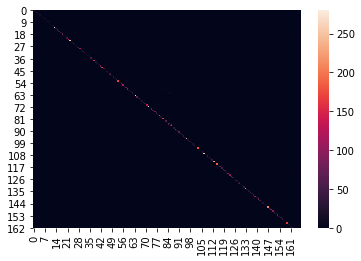

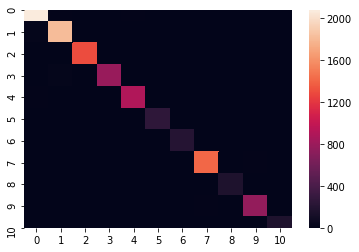

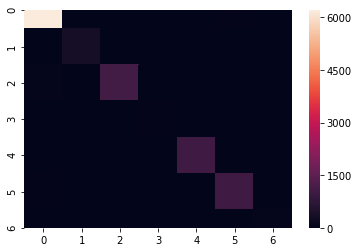

In [33]:
for y_true, y_pred in zip(y_trues, y_preds):
    show_confusion_matrix(y_true, y_pred)   
    plt.show()

In [34]:
for y_true, y_pred in zip(y_trues, y_preds):
    metrics = precision_recall_fscore_support(y_true, y_pred,average=None)
    precision, recall, fscore, support = metrics
    data = np.vstack([recall, support, precision, fscore]); data.shape    
    metrics_summary_df = pd.DataFrame(data=data.T, columns=['recall', 'support','precision','fscore'])
    metrics_summary_df = metrics_summary_df.sort_values('recall')
    print(show_most_wrong(metrics_summary_df))
    print("================= I am separation line ============")

       recall  support  precision    fscore
105  0.571429      7.0   1.000000  0.727273
62   0.591837     49.0   0.725000  0.651685
63   0.666667      6.0   1.000000  0.800000
152  0.709677     31.0   0.846154  0.771930
158  0.714286      7.0   1.000000  0.833333
68   0.733333     30.0   0.814815  0.771930
154  0.742857     35.0   0.896552  0.812500
32   0.750000     60.0   0.918367  0.825688
35   0.750000     20.0   1.000000  0.857143
84   0.750000     24.0   0.720000  0.734694
================= I am separation line ============
      recall  support  precision    fscore
5   0.938406    276.0   0.981061  0.959259
10  0.960000    175.0   0.965517  0.962751
8   0.970930    172.0   0.982353  0.976608
6   0.971698    212.0   0.971698  0.971698
3   0.971744    814.0   0.997478  0.984443
9   0.973180    783.0   0.973180  0.973180
4   0.979325    919.0   0.976139  0.977729
1   0.983261   1852.0   0.980614  0.981936
0   0.984813   2107.0   0.974636  0.979698
7   0.988827   1432.0   0.984701  

In [35]:
for y_true, y_pred in zip(y_trues, y_preds):
    metrics = precision_recall_fscore_support(y_true, y_pred,average=None)
    precision, recall, fscore, support = metrics
    data = np.vstack([recall, support, precision, fscore]); data.shape    
    metrics_summary_df = pd.DataFrame(data=data.T, columns=['recall', 'support','precision','fscore'])
    metrics_summary_df = metrics_summary_df.sort_values('recall')
    print(show_most_wrong(metrics_summary_df))
    print("================= I am separation line ============")

       recall  support  precision    fscore
105  0.571429      7.0   1.000000  0.727273
62   0.591837     49.0   0.725000  0.651685
63   0.666667      6.0   1.000000  0.800000
152  0.709677     31.0   0.846154  0.771930
158  0.714286      7.0   1.000000  0.833333
68   0.733333     30.0   0.814815  0.771930
154  0.742857     35.0   0.896552  0.812500
32   0.750000     60.0   0.918367  0.825688
35   0.750000     20.0   1.000000  0.857143
84   0.750000     24.0   0.720000  0.734694
================= I am separation line ============
      recall  support  precision    fscore
5   0.938406    276.0   0.981061  0.959259
10  0.960000    175.0   0.965517  0.962751
8   0.970930    172.0   0.982353  0.976608
6   0.971698    212.0   0.971698  0.971698
3   0.971744    814.0   0.997478  0.984443
9   0.973180    783.0   0.973180  0.973180
4   0.979325    919.0   0.976139  0.977729
1   0.983261   1852.0   0.980614  0.981936
0   0.984813   2107.0   0.974636  0.979698
7   0.988827   1432.0   0.984701  